# Informe del Análisis de Calidad de Datos: 

#### 15 de Noviembre de 2024

Documentar en formato markdown los resultados del análisis de calidad de los datos, identificando problemas encontrados (como valores faltantes o inconsistencias) y detallando las soluciones implementadas para garantizar la confiabilidad del análisis posterior.

## 1. Descripción de los datos de **Cash Requests (CR)**
   ### 1. Enumeración de Campos y Posibles Valores

1. **`status`**  
   - **Descripción:** Estado del Cash Request (CR).  
   - **Posibles valores:**
     - `approved`: Aprobado automáticamente o manualmente; los fondos se enviarán.
     - `money_sent`: Fondos transferidos al cliente; cambiará a `active` cuando el cliente los reciba.
     - `rejected`: CR revisado manualmente y rechazado.
     - `pending`: Pendiente de revisión manual.
     - `transaction_declined`: Error en la transferencia de fondos.
     - `waiting_user_confirmation`: El usuario debe confirmar la solicitud.
     - `direct_debit_rejected`: Débito directo SEPA rechazado.
     - `canceled`: Solicitud cancelada por falta de confirmación del usuario.
     - `direct_debit_sent`: Débito directo programado pero no confirmado.
     - `waiting_reimbursement`: Reembolso pendiente de selección de fecha.
     - `active`: Fondos recibidos en la cuenta del cliente.
     - `money_back`: CR reembolsado exitosamente.
3. **`created_at`**  
   - **Descripción:** Fecha y hora de creación del CR.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

4. **`updated_at`**  
   - **Descripción:** Fecha y hora de la última actualización del CR.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

5. **`user_id`**  
   - **Descripción:** ID único del usuario que solicitó el CR.  
   - **Posibles valores:** Identificador único.

6. **`moderated_at`**  
   - **Descripción:** Fecha y hora de la revisión manual (si aplica).  
   - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

7. **`deleted_account_id`**  
   - **Descripción:** ID de usuario anonimizado si la cuenta fue eliminada.  
   - **Posibles valores:** Identificador único o `null`.

8. **`reimbursement_date`**  
   - **Descripción:** Fecha planificada para el reembolso.  
   - **Posibles valores:** Fecha (ISO 8601).

9. **`cash_request_debited_date`**  
   - **Descripción:** Fecha del último débito directo observado (si aplica).  
   - **Posibles valores:** Fecha (ISO 8601) o `null`.

10. **`cash_request_received_date`**  
    - **Descripción:** Fecha de recepción del CR por parte del cliente.  
    - **Posibles valores:** Fecha (ISO 8601) o `null`.

11. **`money_back_date`**  
    - **Descripción:** Fecha en que el CR fue reembolsado completamente.  
    - **Posibles valores:** Fecha (ISO 8601) o `null`.

12. **`transfer_type`**  
    - **Descripción:** Tipo de transferencia elegida por el usuario.  
    - **Posibles valores:**
      - `Instant`
      - `Regular`

13. **`send_at`**  
    - **Descripción:** Fecha y hora de la transferencia de fondos.  
    - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

14. **`recovery_status`**  
    - **Descripción:** Estado del incidente de pago (si aplica).  
    - **Posibles valores:**
      - `null`: Sin incidentes de pago.
      - `completed`: Incidente resuelto.
      - `pending`: Incidente abierto.
      - `pending_direct_debit`: Incidente abierto con débito directo lanzado.

15. **`reco_creation`**  
    - **Descripción:** Fecha y hora de creación del caso de recuperación.  
    - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

16. **`reco_last_update`**  
    - **Descripción:** Última fecha de actualización del caso de recuperación.  
    - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

---

### Reflexión y Análisis para EDA

1. **Campos a analizar más en profundidad:**
   - **`status` y `recovery_status`:** Permiten identificar el flujo de estados y posibles incidencias. Útil para análisis de tasas de éxito o problemas operativos.
   - **Tiempos (`created_at`, `updated_at`, `reimbursement_date`, etc.):** Identificar patrones temporales o retrasos en procesos.
   - **`transfer_type`:** Analizar la preferencia de los usuarios entre transferencias instantáneas y regulares.

2. **Transformaciones necesarias:**
   - **Estandarización temporal:** Convertir todas las marcas de tiempo a un formato único y establecer zonas horarias si fuera relevante.
   - **Valores faltantes (`null`):** Imputar valores, reemplazar o analizar su impacto según el contexto del análisis.
   - **Derivación de nuevas variables:** 
     - Duraciones entre eventos clave (e.g., `created_at` y `send_at`).
   - **Outliers:** Identificar valores extremos en campos de fechas o estados que puedan reflejar errores.

   - print('Conclusiones: deleted_account_id y user_id tienen nulos complementarios')
   - print('Conclusiones: reco* solo están informadas para aquellos registros afectados')
   - print('Conclusiones: moderated_at está menos poblada a medida que pasa el tiempo')
   - print('Conclusiones: money_back y raceived están más pobladan a medida que pasa el tiempo')


In [189]:
!pip install --upgrade seaborn statsmodels

# Importar librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [190]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
cash_request = pd.read_csv('../project_dataset/extract - cash request - data analyst.csv')
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
data = cash_request
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [191]:

data.describe()
print('Observación: hay CR con amount de 1$ y de 200$')


Observación: hay CR con amount de 1$ y de 200$


## 2 Análisis de Calidad de Datos 

El análisis de la calidad de datos es una parte fundamental en el proceso de ciencias de datos.Su objetivo es evaluar la integridad,precisión,consistencia y confiabilidad de los datos utilizados en un proyecto o análisis 

1. **Identificación de valores faltantes**: Este paso implica detectar si hay campos o variables en el conjunto de datos que carecen de valores.Los valores faltantes pueden deberse a diversos motivos,como errores en la entrada de datos,fallas en los sistemas de recolección o simplemente la ausencia de información.
2. **Detección de inconsistencias en los datos**: Consiste en buscar discrepancias o contradicciones entre los datos.Por ejemplo, si en un conjunto de datos sobre ventas se encuentra que el número de productos vendidos en un día es mayor que el inventario inicial, esto podría ser una inconsistencia.
3. **Identificación de posibles errores**: Esto implica buscar valores atípicos, anomalías o datos que no tienen sentido dentro delcontexto delconjunto de datos.Los errores pueden manifestarse de diversas formas,como valores extremadamente altos o bajos que no son representativos del resto de los datos, o datos que violan las restricciones lógicas de un dominio específico.
4. **Evaluación de la consistencia y precisión**: Se refiere a verificar si los datos están en concordancia con las expectativas y reglas del dominio del problema.Esto implica comprobar la coherencia de los datos con respecto a las reglas de negocio y los estándares establecidos.
5. **Limpieza de datos**: Una vez identificados los problemas de calidad de los datos, se procede a corregirlos o eliminarlos.Esto puede implicar imputar valores faltantes,corregir errores evidentes o eliminar registros que no cumplen con ciertos criterios de calidad.

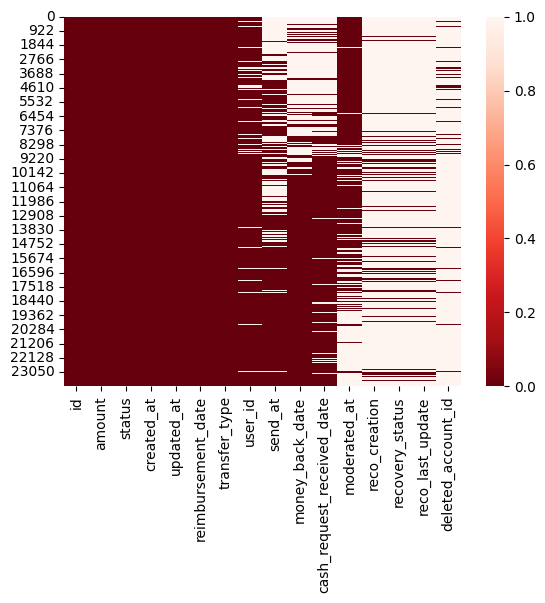

Conclusiones: deleted_account_id y user_id tienen nulos complementarios
Conclusiones: reco* solo están informadas para aquellos registros afectados
Conclusiones: moderated_at está menos poblada a medida que pasa el tiempo
Conclusiones: money_back y raceived están más pobladan a medida que pasa el tiempo


In [192]:
ordered_columns = data.isnull().sum().sort_values().keys()
# Creamos un heatmap con los valores nulos
sns.heatmap(data[ordered_columns].isnull(), annot=False, cmap='Reds_r')
plt.show()

print('Conclusiones: deleted_account_id y user_id tienen nulos complementarios')
print('Conclusiones: reco* solo están informadas para aquellos registros afectados')
print('Conclusiones: moderated_at está menos poblada a medida que pasa el tiempo')
print('Conclusiones: money_back y raceived están más pobladan a medida que pasa el tiempo')

#### 2.0.1 llenar valores faltantes 

Para llenar valores faltantes en conjuntos de datos tanto cuantitativos como cualitativos,existen varias estrategias comunes que los científicos de datos suelen emplear:
- Valores cuantitativos:
    1. **Imputación por la media o mediana**: Los valores faltantes se reemplazan por la media o mediana de la variable en cuestión.Esta estrategia es simple y efectiva cuando los datos siguen una distribución normal y los valores faltantes son aleatorios.
    2. **Imputación por regresión**: Se utiliza un modelo de regresión para predecir los valores faltantes en función de otras variables del conjunto de datos.Esta técnica es útil cuando existe una correlación significativa entre la variable con valores faltantes y otras variables del conjunto de datos.
    3. **Métodos basados en vecinos más cercanos (KNN)**: Los valores faltantes se im    putan utilizando los valores de las observaciones más similares en función de una métrica de distancia. Esta estrategia es útilcuando las observaciones se pueden agrupar en un espacio métrico.
    4. **Imputación múltiple**: Se generan múltiples imputaciones para los valores faltantes,
    teniendo en cuenta la incertidumbre asociada con la imputación.Esta técnica es útil cuando se desea tener en cuenta la variabilidad en los datos imputados.
- Valores cualitativos:
    1. **Moda o valor más frecuente**: Los valores faltantes se reemplazan por elvalor más común o moda de la variable categórica.Esta estrategia es simple y efectiva cuando hay una categoría dominante en la variable.
    2. **Imputación por regresión logística**: Se utiliza un modelo de regresión logística para predecir la categoría de los valores faltantes en función de otras variables delconjunto de datos.
    3. **Muestreo de valores**: Los valores faltantes se imputan seleccionando aleatoriamente valores observados de la misma variable categórica.
    4. **Imputación basada en modelos de clasificación**: Se utilizan modelos de clasificación (como árboles de decisión o métodos de clasificación más avanzados) para predecir la categoría de los valores faltantes en función de otras variables predictoras.

In [193]:
if 'deleted_account_id' in data.columns:

    # Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
    data.fillna({"user_id": data["deleted_account_id"]}, inplace=True)

    # Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
    data.drop(columns=["deleted_account_id"], inplace=True)

# Estandarización de formatos

data['user_id'] = data['user_id'].apply(lambda x: int(x) if x % 1 == 0 else np.nan)

# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
for col in datetime_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce').dt.floor('min').dt.tz_localize(None)
    # data[col] = data[col].dt.floor('h')
    # data[col] = data[col].dt.tz_localize(None)

data.set_index('id', inplace=True)
data.sort_values(by='id', inplace=True)
display(data.head())

data.describe()

amount                 status          created_at          updated_at  \
id                                                                          
3      1.0               canceled 2019-11-19 13:57:00 2020-12-14 10:25:00   
4    100.0             money_back 2019-12-09 14:47:00 2020-11-04 12:54:00   
5    100.0               rejected 2019-12-10 19:05:00 2019-12-11 16:47:00   
6    100.0  direct_debit_rejected 2019-12-10 19:05:00 2020-12-18 22:47:00   
7    100.0               rejected 2019-12-10 19:13:00 2019-12-11 09:46:00   

    user_id        moderated_at  reimbursement_date  \
id                                                    
3        47                 NaT                 NaT   
4      1309                 NaT                 NaT   
5       804 2019-12-11 16:47:00 2020-01-09 19:05:00   
6       812                 NaT                 NaT   
7       191 2019-12-11 09:46:00 2020-01-09 19:13:00   

   cash_request_received_date money_back_date transfer_type send_at  \
id                                                                    
3                         NaT             NaT       regular     NaT   
4                         NaT             NaT       regular     NaT   
5                         NaT             NaT       regular     NaT   
6                  2019-12-11             NaT       regular     NaT   
7                         NaT             NaT       regular     NaT   

   recovery_status       reco_creation    reco_last_update  
id                                                          
3              NaN                 NaT                 NaT  
4              NaN                 NaT                 NaT  
5              NaN                 NaT                 NaT  
6          pending 2020-03-20 14:12:00 2020-12-18 22:47:00  
7              NaN                 NaT                 NaT

amount                     created_at  \
count  23970.000000                          23970   
mean      82.720818  2020-08-18 01:08:43.879849984   
min        1.000000            2019-11-19 13:57:00   
25%       50.000000            2020-07-10 06:58:00   
50%      100.000000            2020-09-02 10:43:00   
75%      100.000000            2020-10-12 13:14:30   
max      200.000000            2020-11-01 23:42:00   
std       26.528065                            NaN   

                          updated_at        user_id  \
count                          23970   23970.000000   
mean   2020-11-01 20:34:12.570713344   30570.545265   
min              2019-12-11 09:46:00      34.000000   
25%              2020-09-16 08:43:45    9269.000000   
50%              2020-12-18 13:09:00   21465.000000   
75%              2020-12-18 13:11:00   43198.500000   
max              2021-02-12 04:15:00  103719.000000   
std                              NaN   27266.706244   

                        moderated_at             reimbursement_date  \
count                          15912                           3050   
mean   2020-07-21 18:42:01.380090624  2020-08-22 05:39:25.160655872   
min              2019-12-11 09:46:00            2019-12-17 19:51:00   
25%              2020-06-22 18:55:30            2020-07-22 10:49:15   
50%              2020-07-29 09:51:00            2020-09-12 06:00:30   
75%              2020-09-07 15:15:30            2020-10-17 20:44:15   
max              2020-11-02 09:06:00            2020-12-31 09:58:00   
std                              NaN                            NaN   

          cash_request_received_date                money_back_date  \
count                          16289                          12040   
mean   2020-08-26 09:17:07.024372480  2020-10-07 06:29:46.300664576   
min              2019-12-10 00:00:00            2020-02-28 14:16:00   
25%              2020-07-17 00:00:00            2020-09-11 19:24:00   
50%              2020-09-15 00:00:00            2020-11-02 19:33:00   
75%              2020-10-20 00:00:00            2020-11-09 19:06:00   
max              2020-11-27 00:00:00            2021-02-12 04:15:00   
std                              NaN                            NaN   

                             send_at                  reco_creation  \
count                          16466                           3330   
mean   2020-09-26 08:34:03.148305664  2020-10-05 01:46:15.009008896   
min              2020-07-27 13:02:00            2020-03-19 22:10:00   
25%              2020-08-31 16:28:15            2020-08-22 22:09:00   
50%              2020-10-06 14:25:30            2020-10-21 22:23:00   
75%              2020-10-21 07:11:00            2020-11-18 22:50:00   
max              2020-11-08 22:04:00            2021-02-11 23:08:00   
std                              NaN                            NaN   

                    reco_last_update  
count                           3330  
mean   2020-10-30 00:38:17.621621504  
min              2020-03-31 16:05:00  
25%              2020-09-29 22:08:00  
50%              2020-11-14 22:57:00  
75%              2020-12-10 10:16:15  
max              2021-02-12 04:15:00  
std                              NaN

3. **Identificación de posibles errores**: Esto implica buscar valores atípicos, anomalías o datos que no tienen sentido dentro delcontexto delconjunto de datos.Los errores pueden manifestarse de diversas formas,como valores extremadamente altos o bajos que no son representativos del resto de los datos, o datos que violan las restricciones lógicas de un dominio específico.

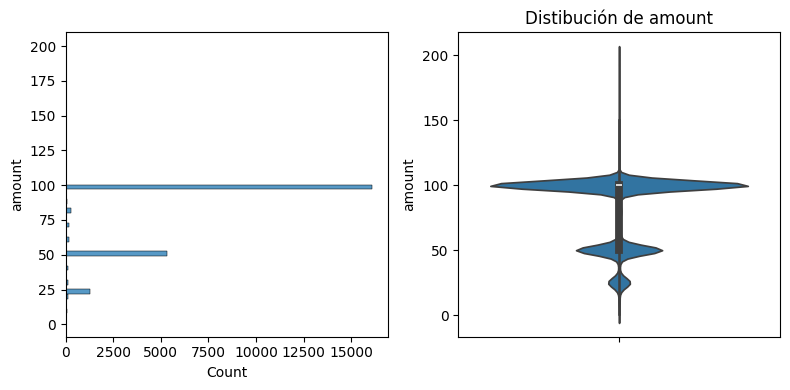

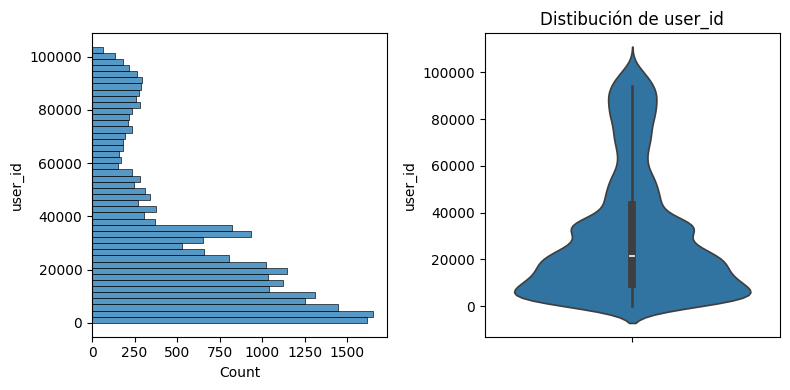

Conclusiones: Existen Amounts de 200, pero nada indica que sean errores


In [194]:
columnas_numericas = data.describe().columns.tolist()

for c in columnas_numericas:
    if data[c].dtype.kind != 'M':
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        sns.violinplot(y=c, data=data, ax=axs[1])
        sns.histplot(y=c, data=data, ax=axs[0])
        plt.title(f'Distibución de {c}')
        plt.tight_layout()
        plt.show()


print('Conclusiones: Existen Amounts de 200, pero nada indica que sean errores')

amount
100.0    16094
50.0      5304
25.0      1276
80.0       267
60.0       190
70.0       151
20.0       132
Name: count, dtype: int64

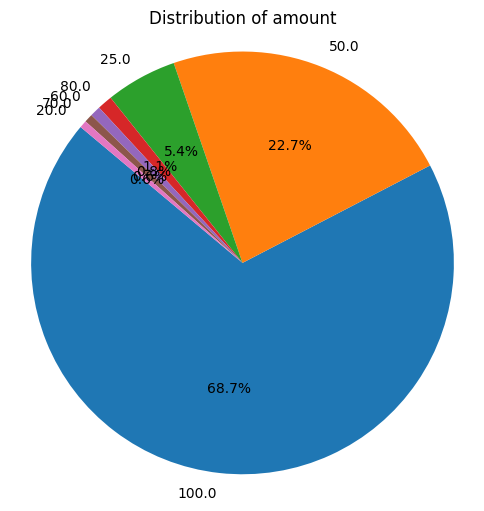

status
money_back               16397
rejected                  6568
direct_debit_rejected      831
active                      59
transaction_declined        48
direct_debit_sent           34
canceled                    33
Name: count, dtype: int64

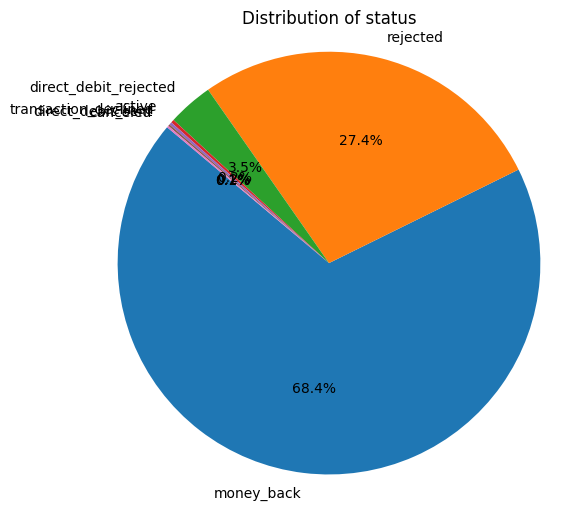

created_at
2020-10-23 16:20:00    13
2020-10-23 16:21:00    11
2020-10-26 16:49:00     9
2020-06-30 10:31:00     8
2020-10-26 16:48:00     7
2020-06-30 10:30:00     7
2020-10-30 16:57:00     7
Name: count, dtype: int64

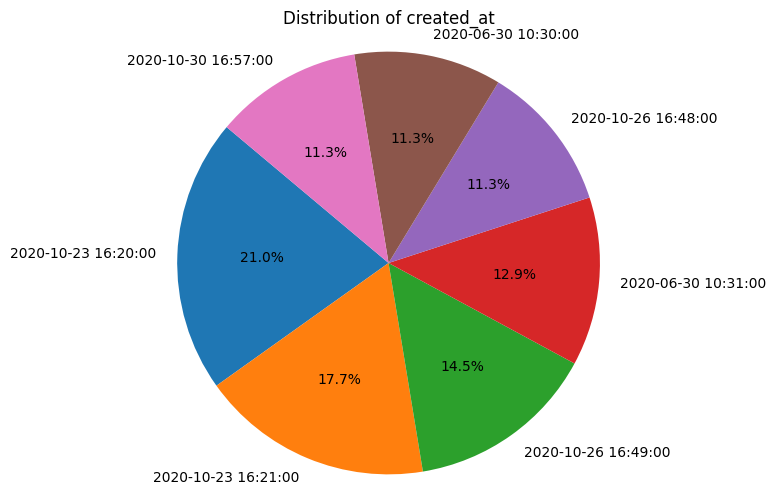

updated_at
2020-12-18 13:09:00    2886
2020-12-18 13:10:00    2617
2020-12-18 13:11:00    2562
2020-12-18 13:12:00    2428
2020-12-18 13:08:00    1663
2020-12-18 13:13:00    1276
2020-11-04 12:55:00     722
Name: count, dtype: int64

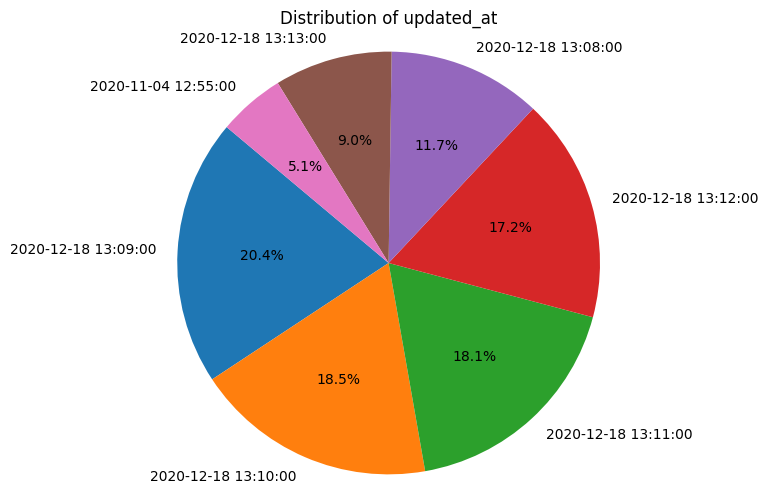

user_id
2142     21
3377     19
6334     19
13851    18
15219    17
10086    17
2530     17
Name: count, dtype: int64

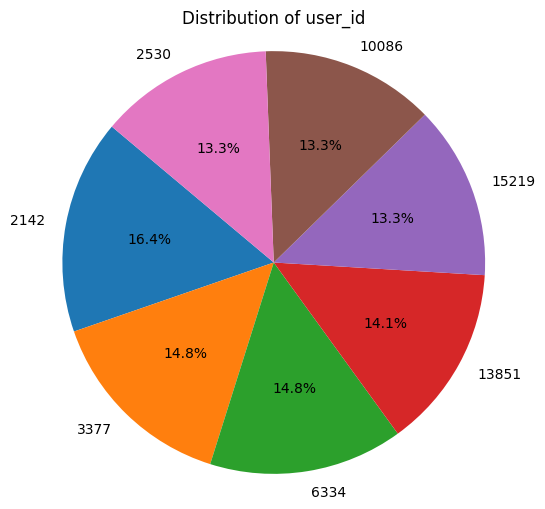

moderated_at
2020-09-02 08:43:00    7
2020-07-08 13:47:00    7
2020-07-12 16:19:00    7
2020-07-21 13:49:00    6
2020-07-11 16:50:00    6
2020-01-10 16:58:00    6
2020-07-20 19:19:00    6
Name: count, dtype: int64

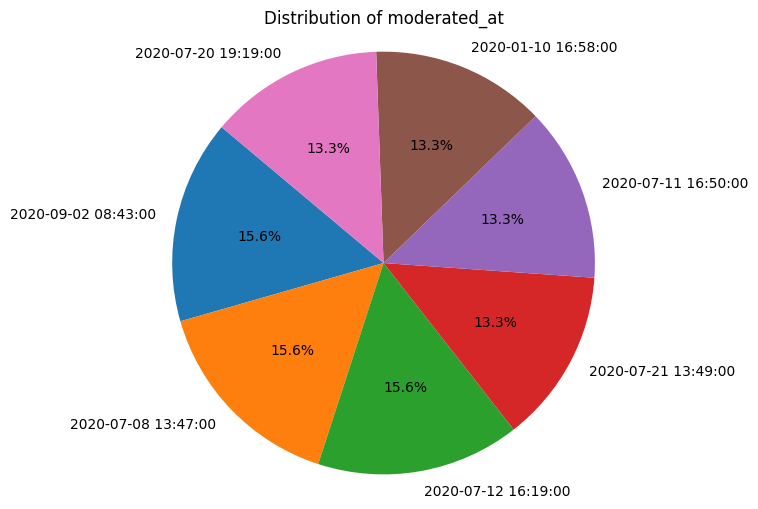

reimbursement_date
2020-02-26 05:00:00    3
2020-11-07 16:20:00    3
2020-11-14 16:55:00    3
2020-10-16 08:57:00    2
2020-09-05 16:53:00    2
2020-09-12 05:47:00    2
2020-09-04 07:41:00    2
Name: count, dtype: int64

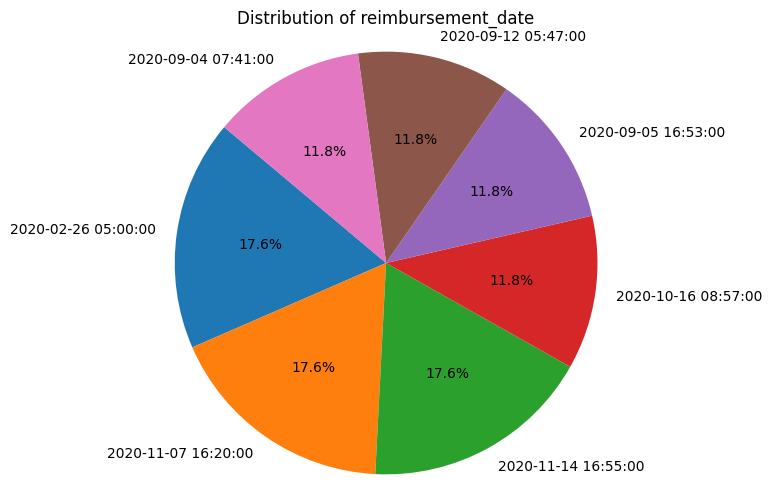

cash_request_received_date
2020-10-27    716
2020-10-28    482
2020-10-30    435
2020-10-20    355
2020-11-03    345
2020-10-24    309
2020-10-13    271
Name: count, dtype: int64

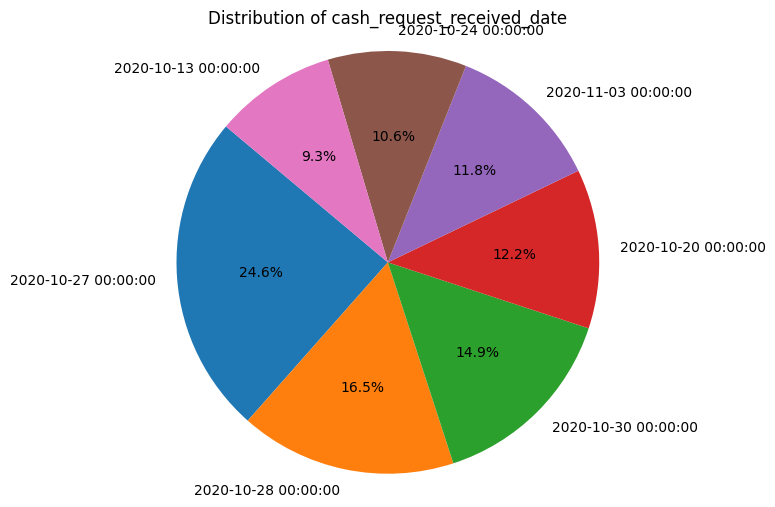

money_back_date
2020-06-09 22:50:00    56
2020-05-15 21:35:00    43
2020-07-03 03:17:00    39
2020-04-14 20:26:00    37
2020-05-19 20:06:00    28
2020-05-13 20:40:00    27
2020-05-12 20:20:00    26
Name: count, dtype: int64

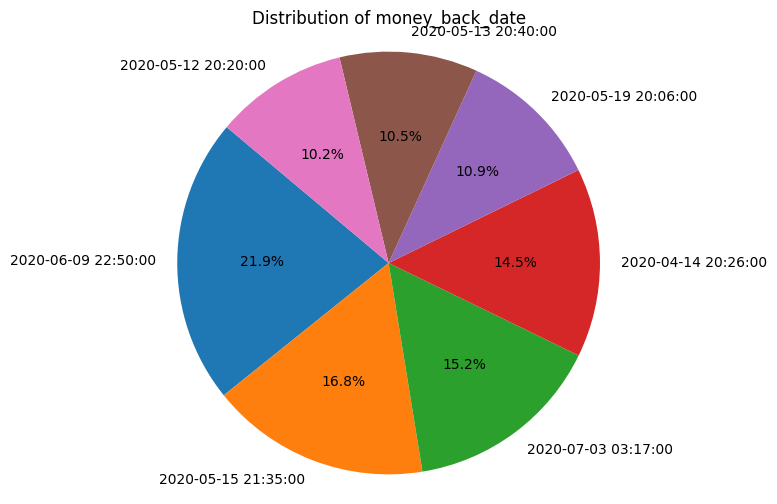

transfer_type
instant    13882
regular    10088
Name: count, dtype: int64

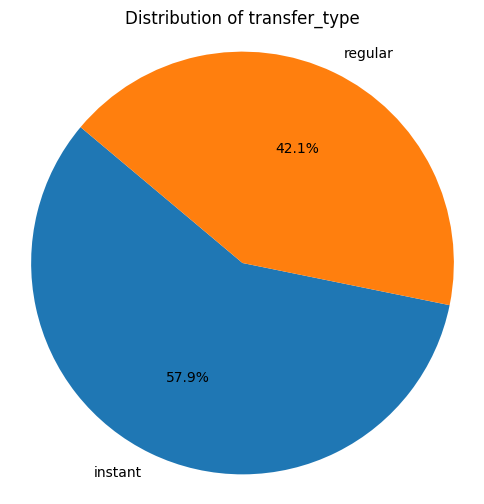

send_at
2020-10-23 16:20:00    12
2020-10-26 16:49:00     9
2020-10-23 16:22:00     8
2020-10-26 16:50:00     7
2020-08-26 16:23:00     6
2020-10-30 12:12:00     5
2020-10-15 16:24:00     5
Name: count, dtype: int64

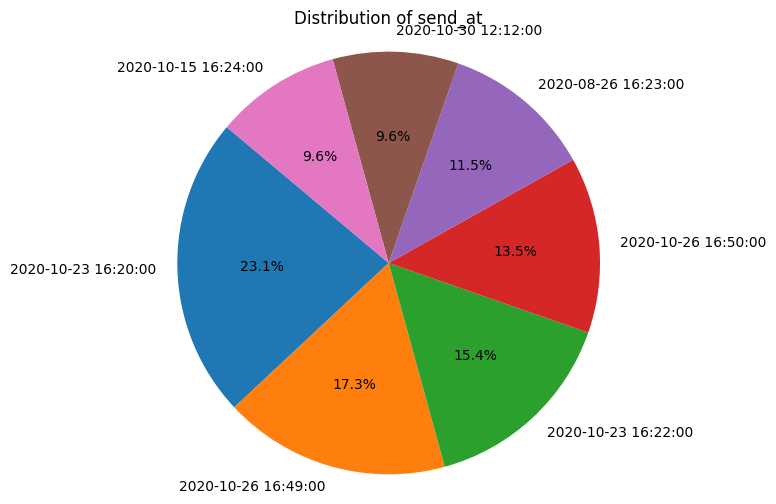

recovery_status
completed               2468
pending                  845
pending_direct_debit      16
cancelled                  1
Name: count, dtype: int64

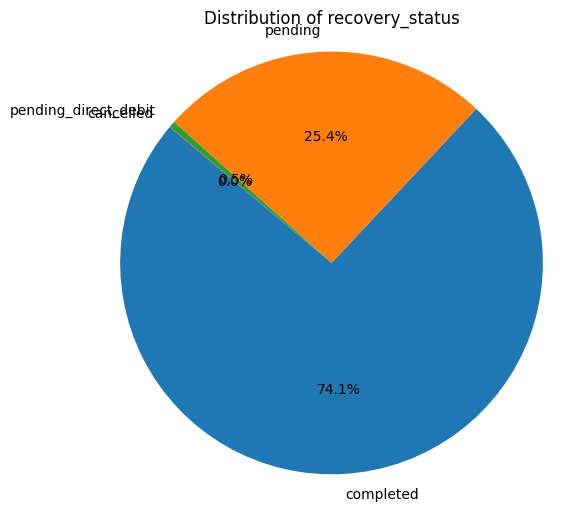

reco_creation
2020-03-20 14:12:00    35
2020-11-15 22:17:00    35
2020-11-18 22:20:00    26
2020-11-25 22:16:00    25
2020-11-18 22:18:00    23
2020-09-09 20:51:00    22
2020-11-18 22:19:00    22
Name: count, dtype: int64

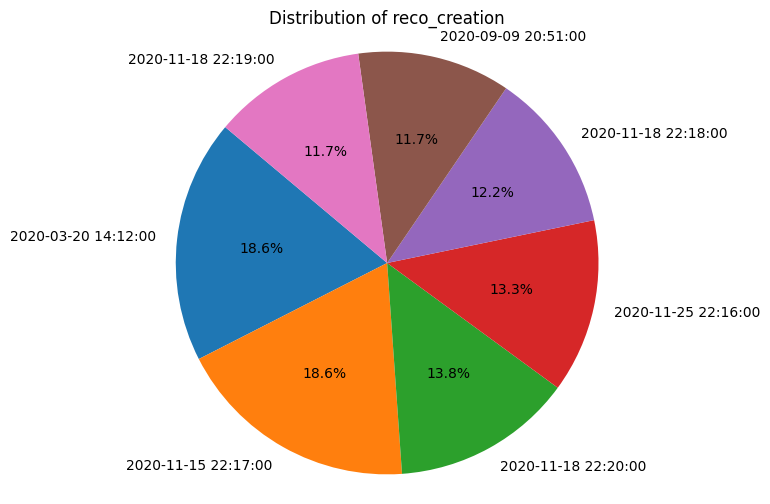

reco_last_update
2020-12-18 22:12:00    15
2020-03-31 16:05:00    13
2020-12-18 22:46:00    10
2020-11-15 22:17:00    10
2020-10-11 22:48:00    10
2020-12-23 22:16:00    10
2020-10-10 22:26:00     8
Name: count, dtype: int64

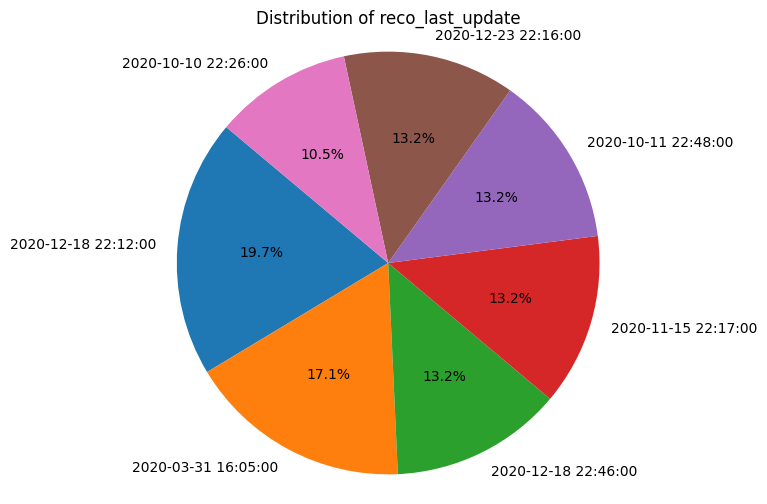

Observación: amount más común es 100.0(16094), 50.0 (5304), 25.0 (1276)
Observación: el usuario que más cash request hasolicitado es 2142 (21)


In [195]:
for c in data.columns.tolist():
    reason_counts = data[c].value_counts().head(7)
    display(reason_counts.head(7))
    # Create a pie plot using Seaborn for the 'status' column
    plt.figure(figsize=(6, 6))
    plt.title(f'Distribution of {c}')
    plt.legend = True
    plt.pie(reason_counts, labels=reason_counts.index.tolist(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

print('Observación: amount más común es 100.0(16094), 50.0 (5304), 25.0 (1276)')
print('Observación: el usuario que más cash request hasolicitado es 2142 (21)')

4. **Evaluación de la consistencia y precisión**: Se refiere a verificar si los datos están en concordancia con las expectativas y reglas del dominio del problema.Esto implica comprobar la coherencia de los datos con respecto a las reglas de negocio y los estándares establecidos.

In [210]:
# Buscar inconsistencias en las fechas

# datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
data[data['created_at'] > data['updated_at']].reset_index()[['id']].count()
data[data['reimbursement_date'] > data['money_back_date']].reset_index()[['id']].count()


display(data.reset_index().groupby(by=['status','recovery_status'])['id'].count().sort_values().sort_values(ascending=False).head(50))

display(data.reset_index().groupby(by=['amount'])['id'].count().sort_values(ascending=False).head(10))

status                 recovery_status     
money_back             completed               2460
direct_debit_rejected  pending                  812
active                 pending                   33
direct_debit_sent      pending_direct_debit      16
direct_debit_rejected  completed                  8
transaction_declined   cancelled                  1
Name: id, dtype: int64

amount
100.0    16094
50.0      5304
25.0      1276
80.0       267
60.0       190
70.0       151
20.0       132
30.0       114
40.0       100
90.0        91
Name: id, dtype: int64

### 3.2 Resumen del Análisis Exploratorio de Datos (AED)

El análisis exploratorio de datos (AED) es la brújula que nos guía a través del vasto territorio de nuestros conjuntos de datos.Nos sumerge en la riqueza de la información,revelando patrones,
tendencias y anomalías que pueden pasar desapercibidas a simple vista.Desde la distribución de calificaciones hasta la correlación entre variables,el AED nos proporciona una comprensión profunda de nuestros datos y nos ayuda a formular hipótesis valiosas para análisis posteriores.

#### 3.2.2 Componentes del AED:

1. **Exploración de Datos Univariable**: Análisis de una variable a la vez para comprender su distribución y estadísticas descriptivas.Este enfoque nos permite entender la naturaleza de cada variable y cómo se distribuyen en el conjunto de datos.
2. **Exploración de Datos Bivariable**: Análisis de la relación entre dos variables para identificar posibles asociaciones o correlaciones.Este análisis nos ayuda a comprender las interacciones entre diferentes variables y su impacto en los resultados.
3. **Identificación de Valores Atípicos**: Detección de puntos que se desvían significativamente de la tendencia general de los datos.La identificación de valores atípicos nos permite comprender mejor la distribución de los datos y evaluar su influencia en nuestros análisis.

### 3.3 Insights de Calidad de Datos 

La calidad de los datos es la piedra angular de cualquier análisis significativo.Los datos incompletos,incorrectos o inconsistentes pueden socavar la validez de nuestros resultados y conducir a conclusiones erróneas.Por lo tanto, es crucial realizar una evaluación rigurosa de la calidad de los datos y tomar medidas para abordar cualquier problema identificado.

#### 3.3.2 Estrategias de Mejora de Calidad de Datos:

1. **Limpieza de Datos**: Identificación y corrección de errores, valores atípicos y datos faltantes.
La limpieza de datos es un proceso esencialpara garantizar la integridad y la precisión de nuestros análisis.
2. **Validación de Datos**: Verificación de la precisión y consistencia de los datos mediante técnicas como la validación cruzada.La validación de datos nos ayuda a confirmar la calidad de nuestros datos y a identificar posibles problemas.
3. **Actualización Regular**: Mantenimiento constante de la integridad de los datos mediante actualizaciones periódicas y revisión continua.La actualización regular de los datos garantiza que estén actualizados y reflejen con precisión la realidad en curso.

### 3.4 Resultados del Análisis de Cohortes 

El análisis de cohortes es una herramienta poderosa para comprender cómo se comportan grupos de individuos a lo largo del tiempo.Al dividir a los usuarios en cohortes basadas en ciertos criterios
(por ejemplo, fecha de inscripción), podemos rastrear su comportamiento y evaluar el impacto de diferentes factores en su experiencia.

#### 3.4.2 Beneficios del Análisis de Cohortes:

1. **Identificación de Tendencias a Largo Plazo**: Permite observar cómo cambian los comportamientos a lo largo del tiempo.El análisis de cohortes nos proporciona una visión a largo plazo de la evolución del comportamiento de los usuarios.
2. **Comparación entre Grupos Homogéneos**: Facilita la comparación de diferentes cohortes con características similares.Esto nos ayuda a comprender mejor las diferencias en elcomportamiento de los usuarios y a identificar áreas de mejora.
3. **Evaluación del Impacto de Intervenciones**: Ayuda a evaluar el efecto de cambios o intervenciones en la experiencia delusuario. El análisis de cohortes nos permite medir el impacto de nuestras acciones y ajustar nuestras estrategias en consecuencia.


Gráfico de dispersión de amount vs created_at


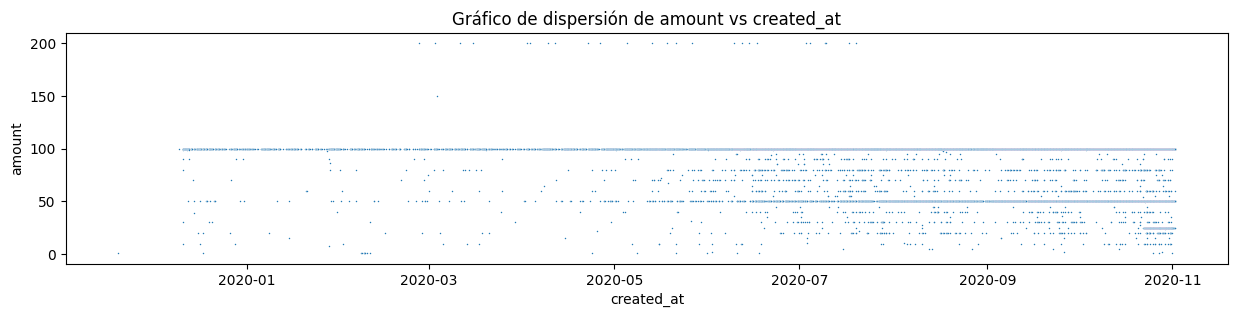

Gráfico de dispersión de amount vs updated_at


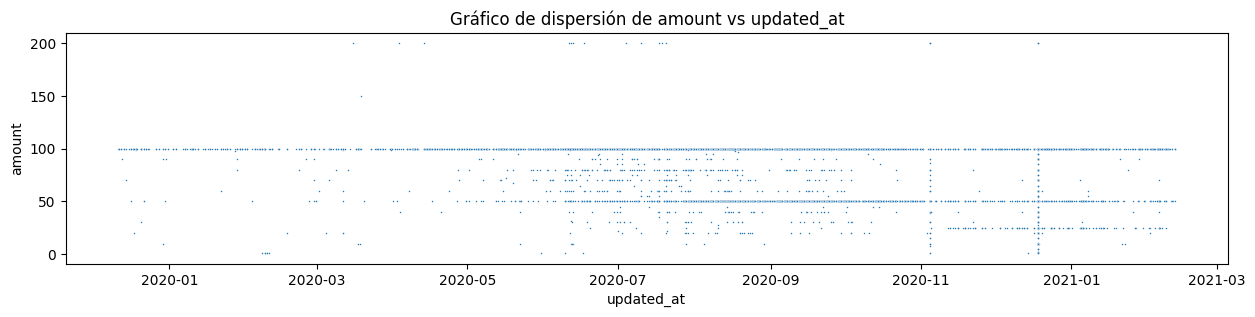

Gráfico de dispersión de amount vs user_id


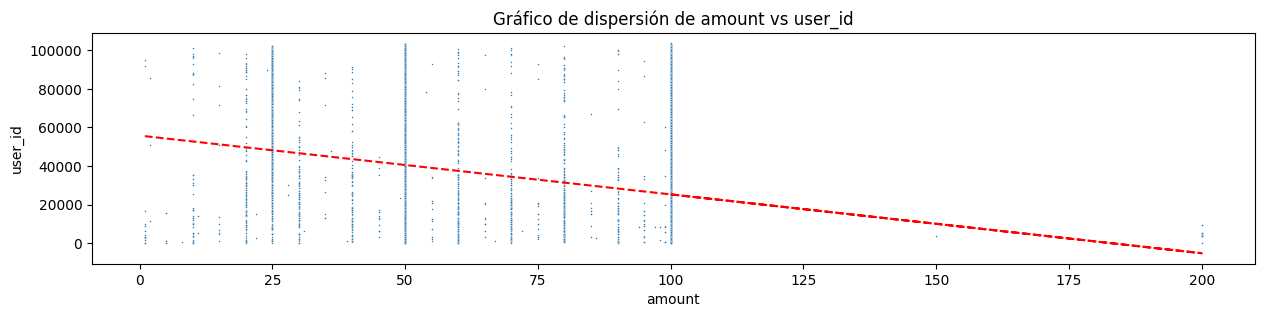

Gráfico de dispersión de amount vs moderated_at


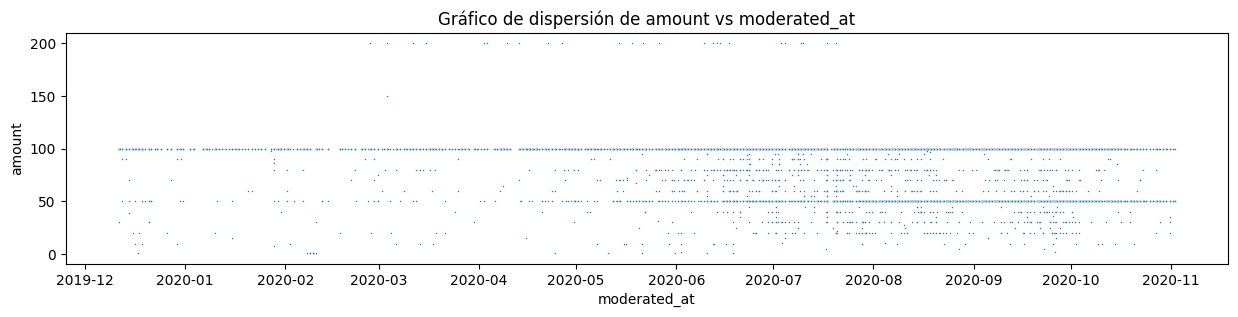

Gráfico de dispersión de amount vs reimbursement_date


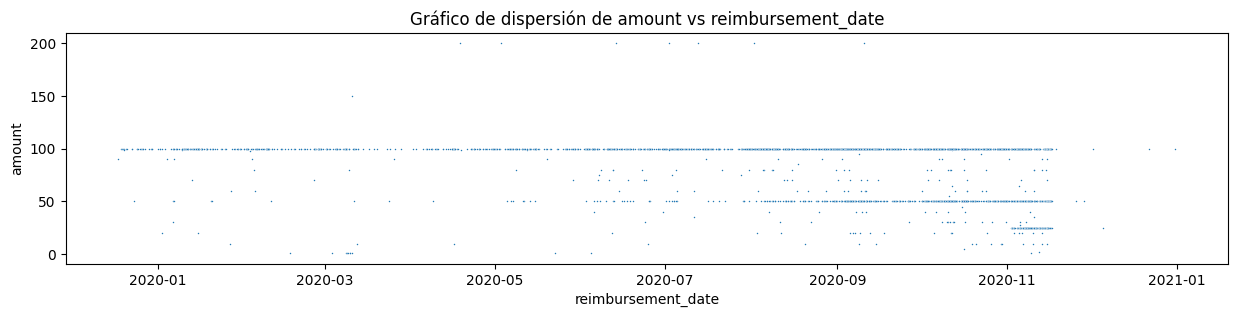

Gráfico de dispersión de amount vs cash_request_received_date


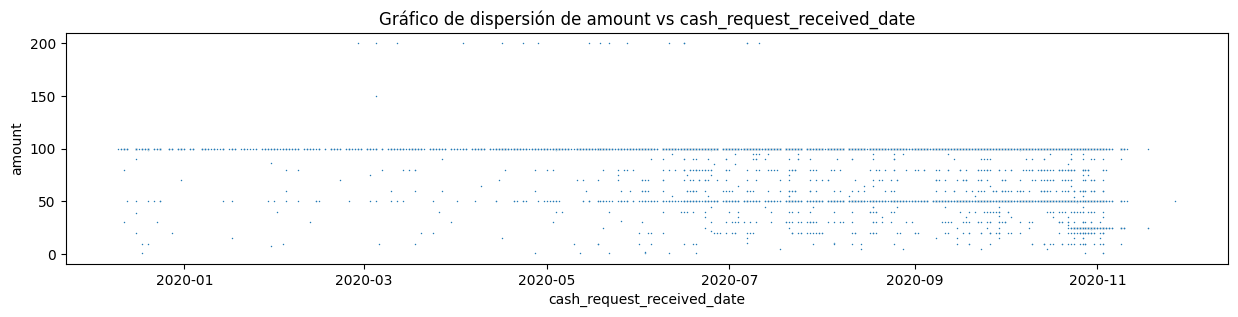

Gráfico de dispersión de amount vs money_back_date


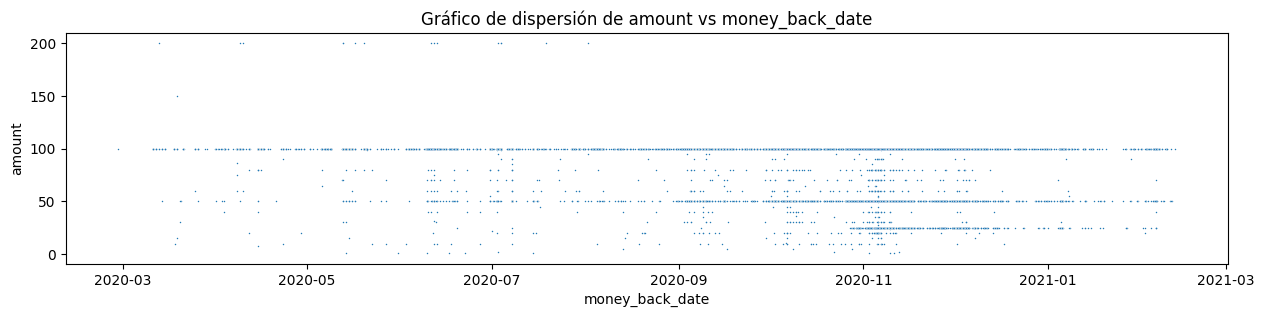

Gráfico de dispersión de amount vs send_at


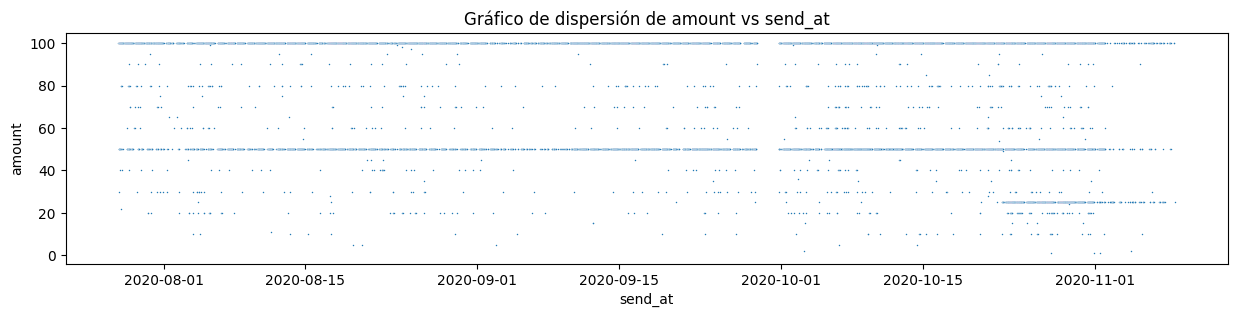

Gráfico de dispersión de amount vs reco_creation


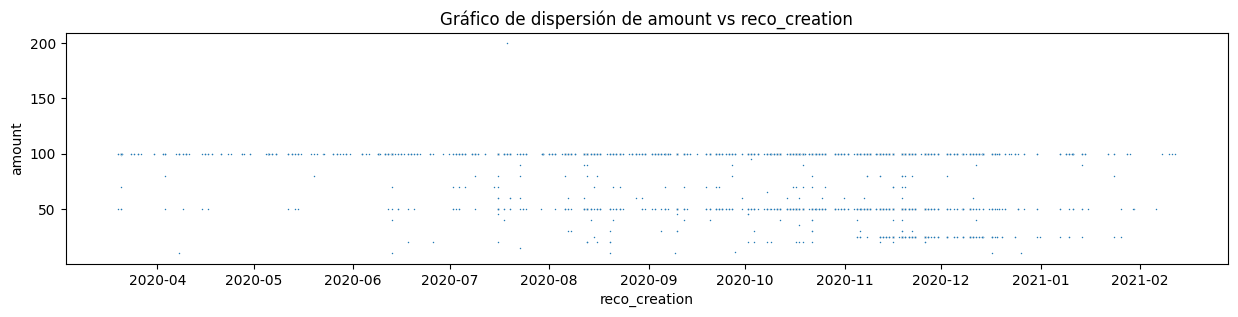

Gráfico de dispersión de amount vs reco_last_update


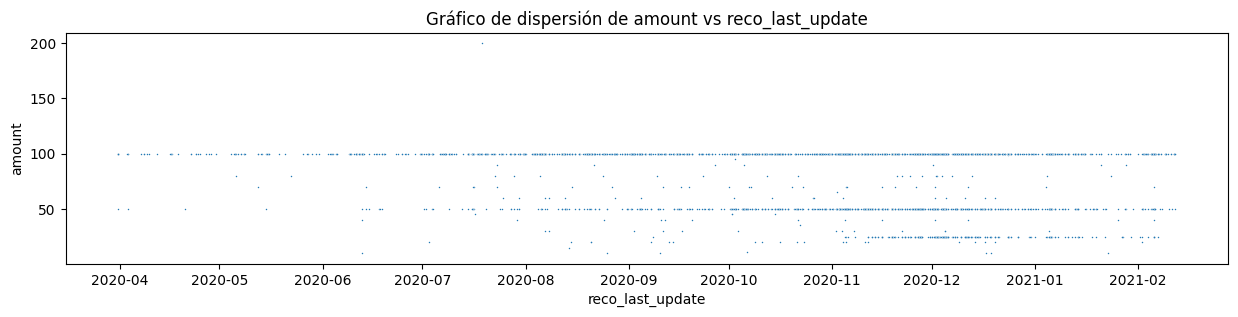

Gráfico de dispersión de created_at vs updated_at


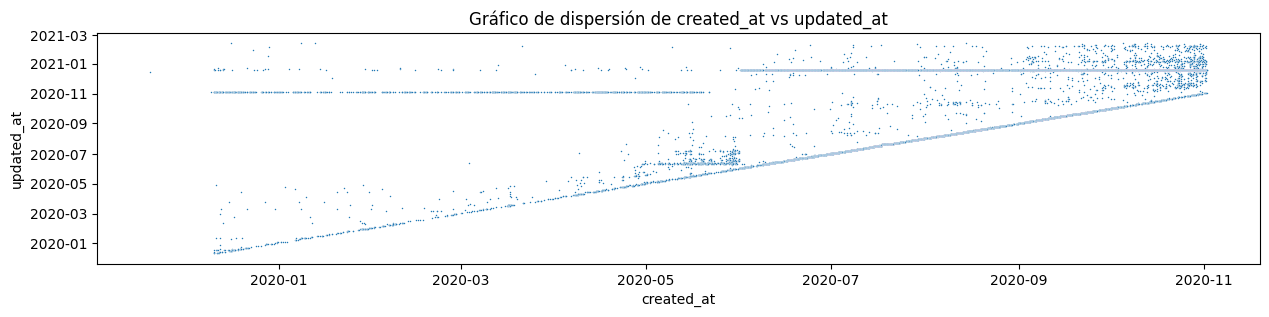

Gráfico de dispersión de created_at vs user_id


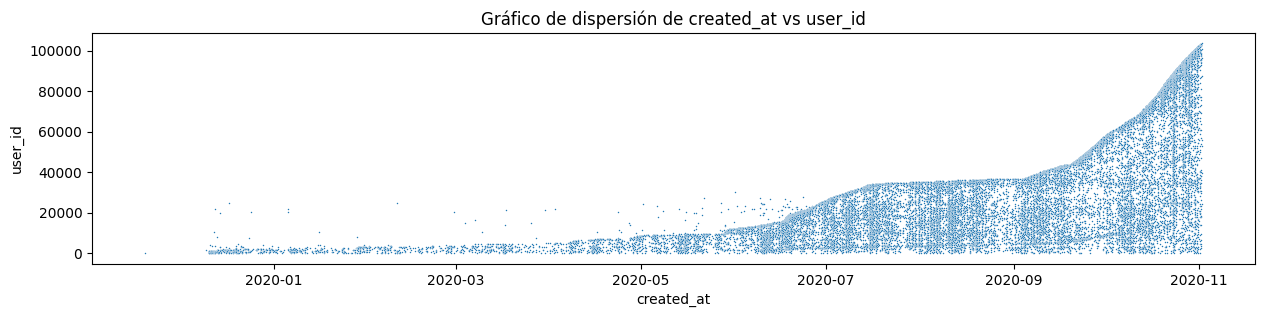

Gráfico de dispersión de created_at vs moderated_at


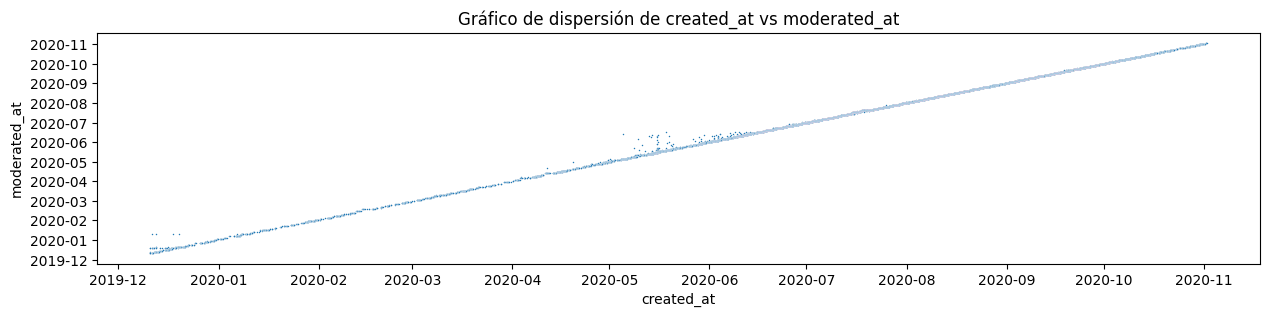

Gráfico de dispersión de created_at vs reimbursement_date


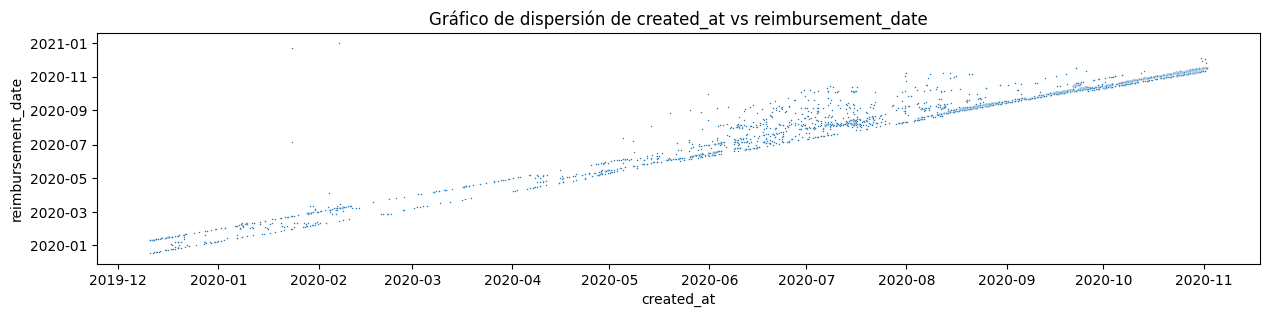

Gráfico de dispersión de created_at vs cash_request_received_date


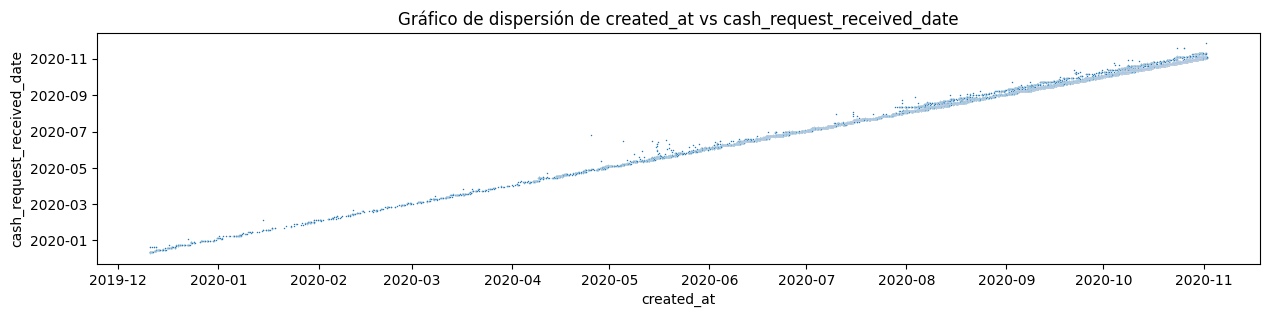

Gráfico de dispersión de created_at vs money_back_date


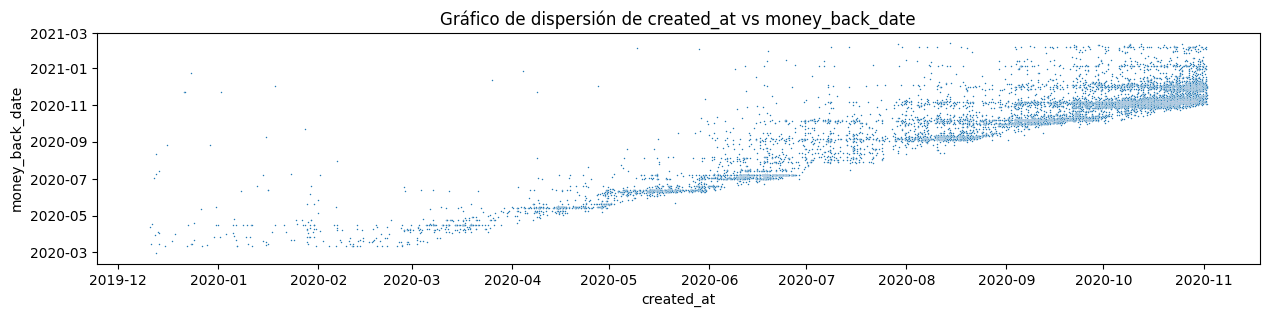

Gráfico de dispersión de created_at vs send_at


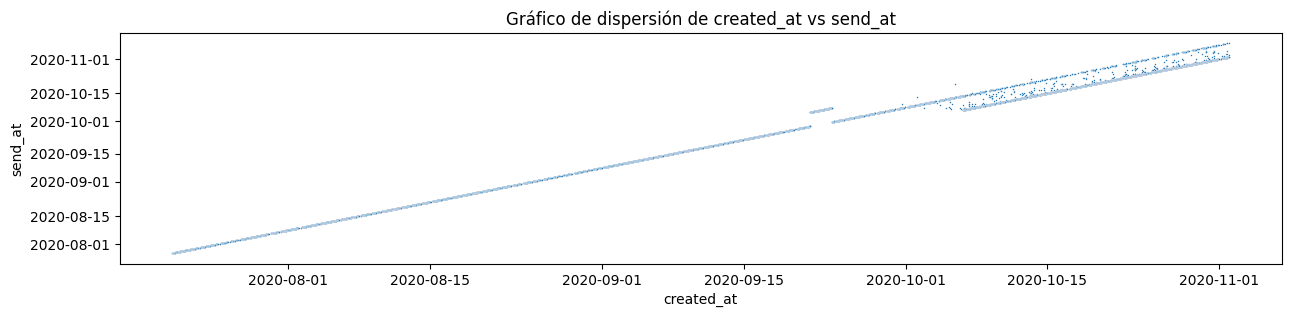

Gráfico de dispersión de created_at vs reco_creation


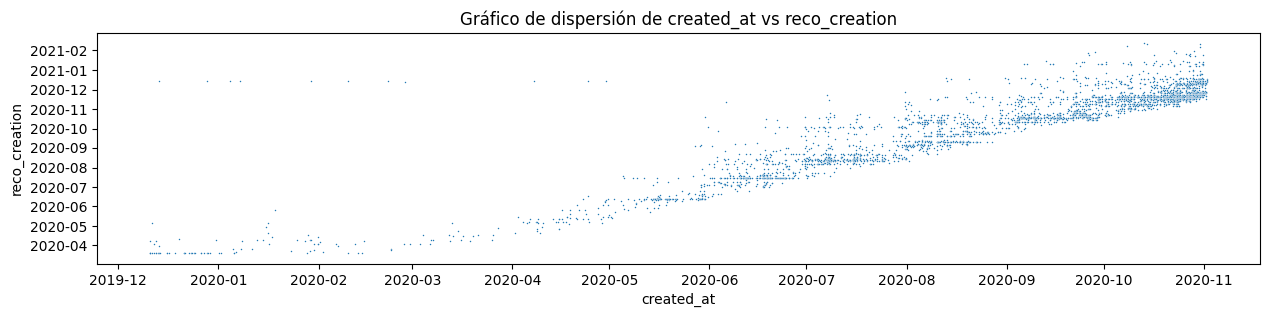

Gráfico de dispersión de created_at vs reco_last_update


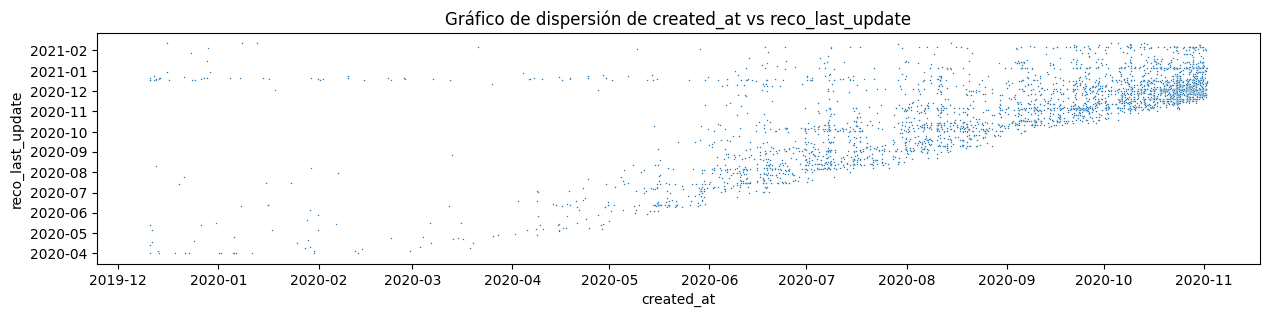

Gráfico de dispersión de updated_at vs user_id


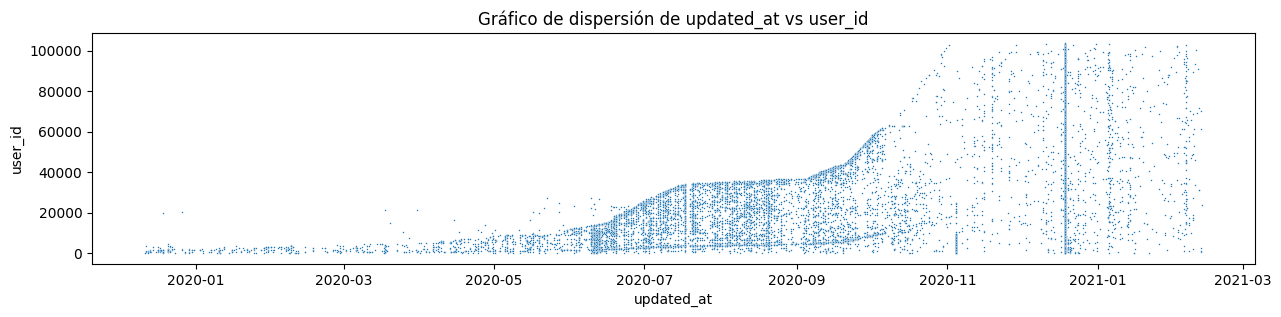

Gráfico de dispersión de updated_at vs moderated_at


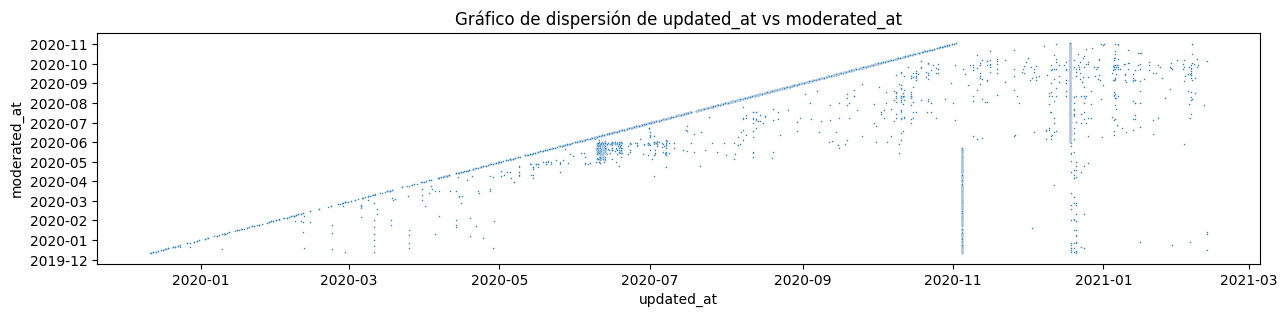

Gráfico de dispersión de updated_at vs reimbursement_date


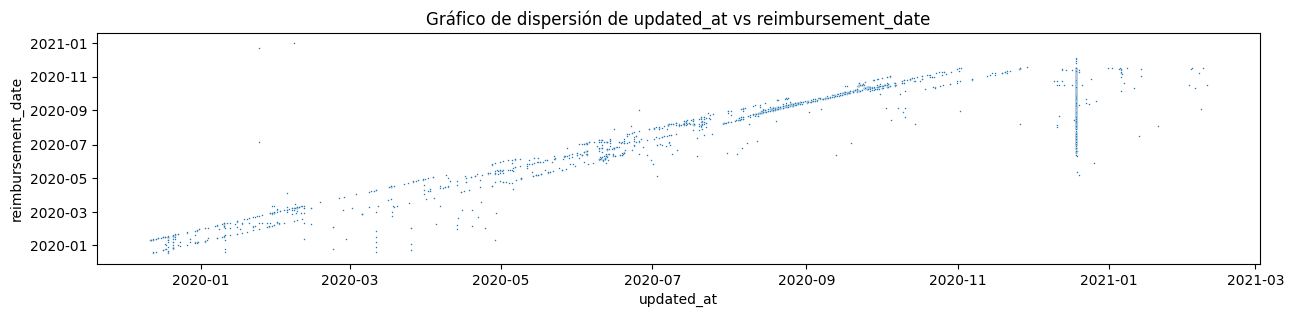

Gráfico de dispersión de updated_at vs cash_request_received_date


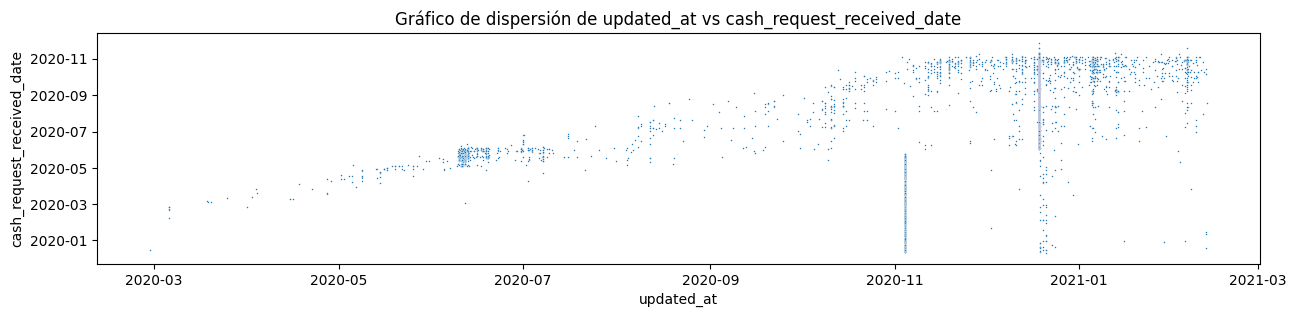

Gráfico de dispersión de updated_at vs money_back_date


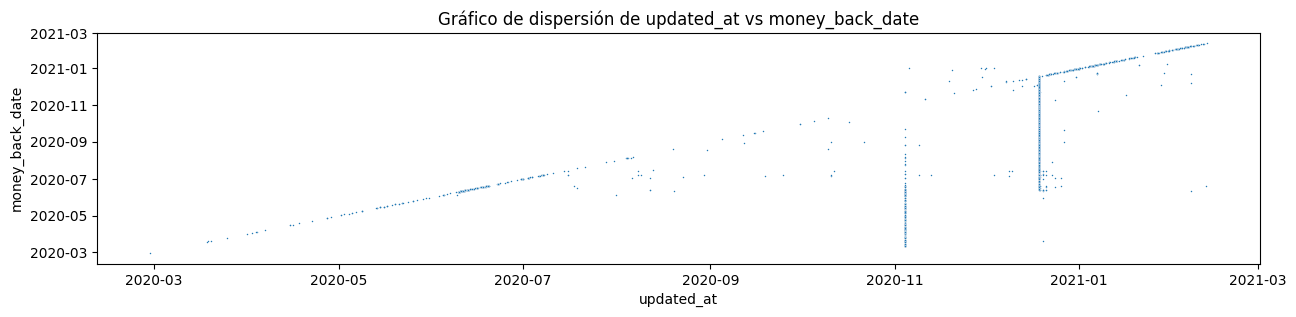

Gráfico de dispersión de updated_at vs send_at


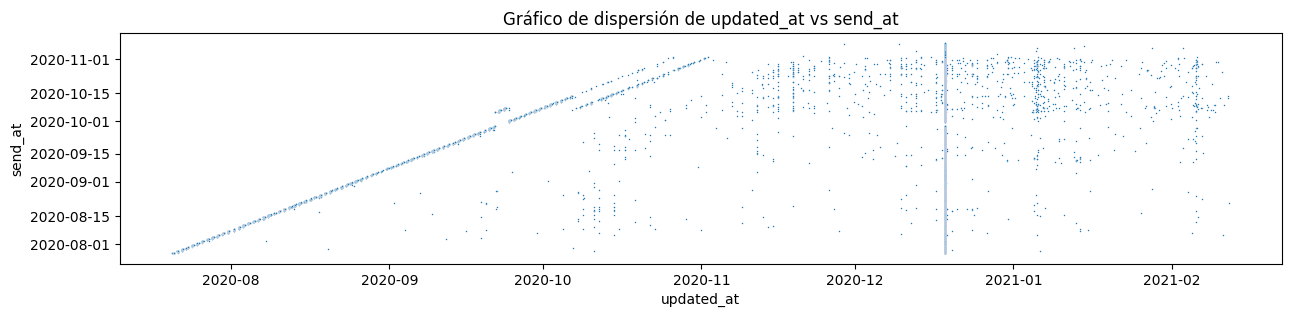

Gráfico de dispersión de updated_at vs reco_creation


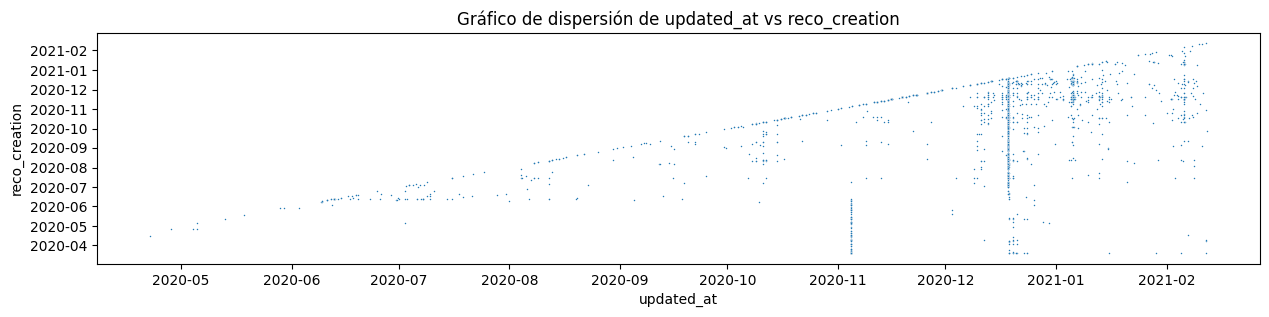

Gráfico de dispersión de updated_at vs reco_last_update


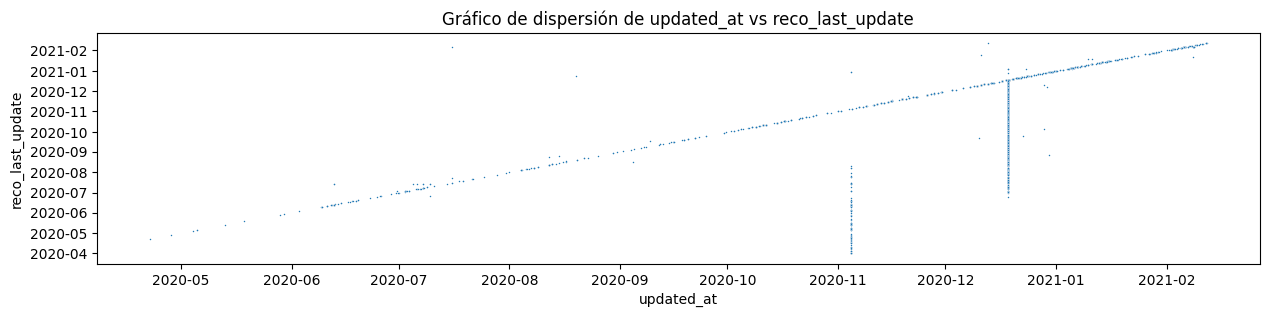

Gráfico de dispersión de user_id vs moderated_at


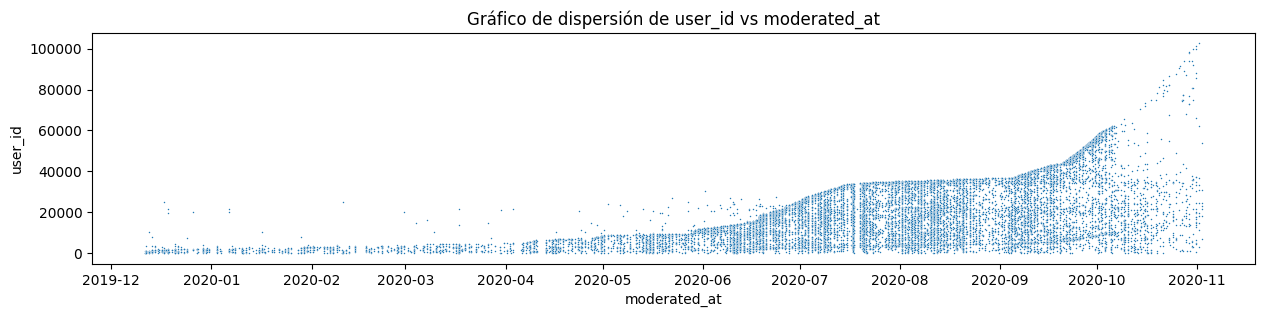

Gráfico de dispersión de user_id vs reimbursement_date


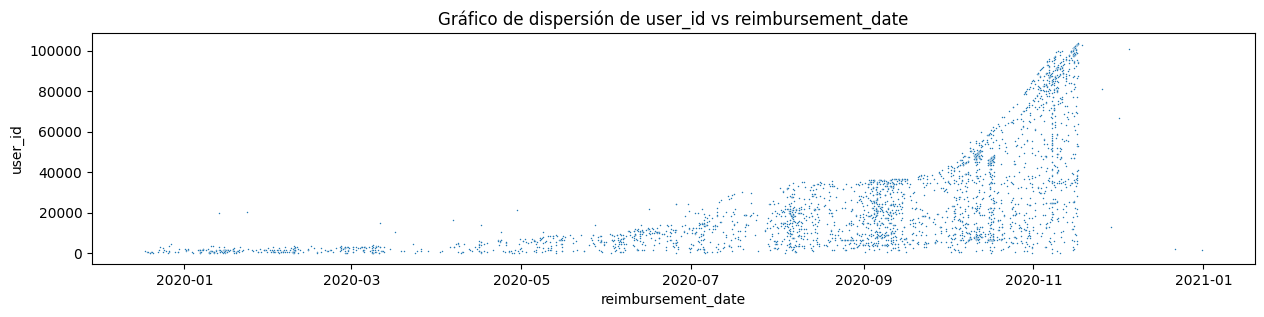

Gráfico de dispersión de user_id vs cash_request_received_date


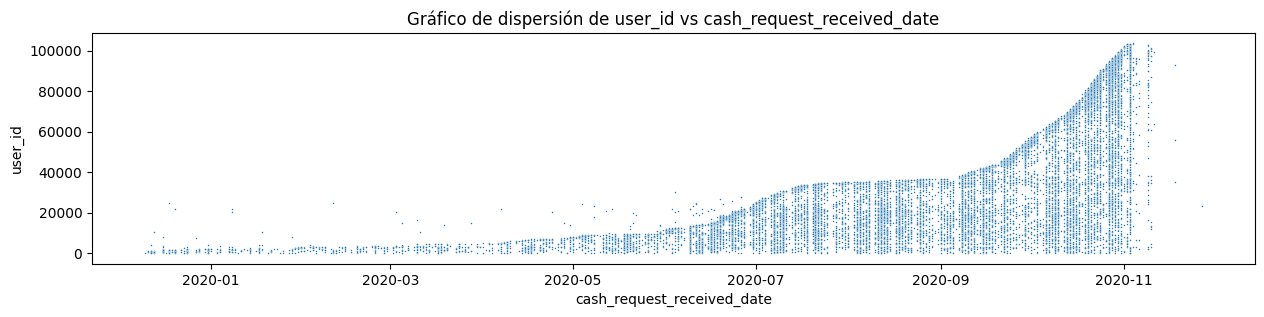

Gráfico de dispersión de user_id vs money_back_date


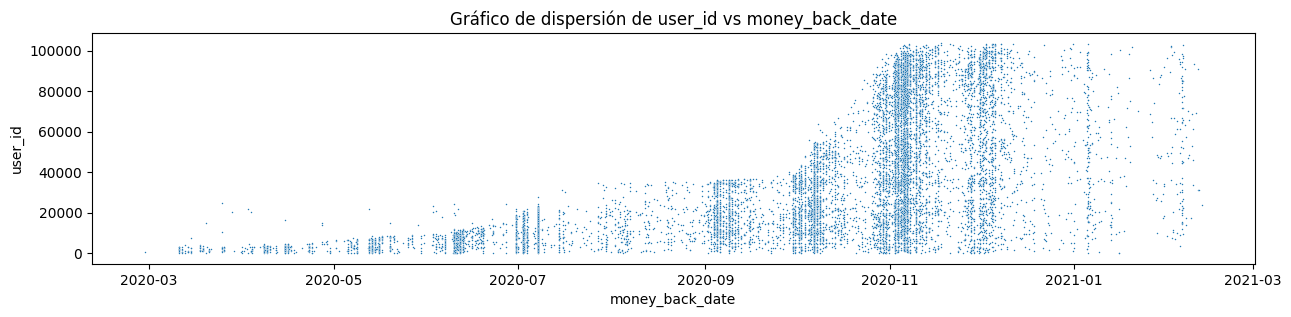

Gráfico de dispersión de user_id vs send_at


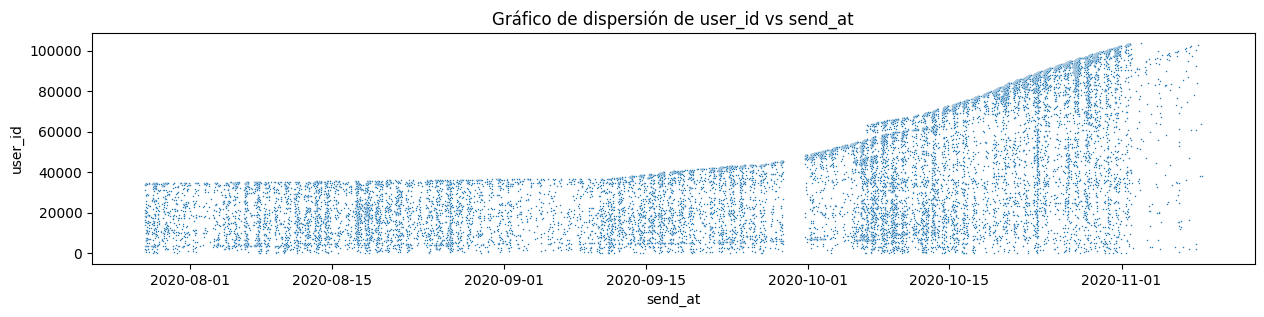

Gráfico de dispersión de user_id vs reco_creation


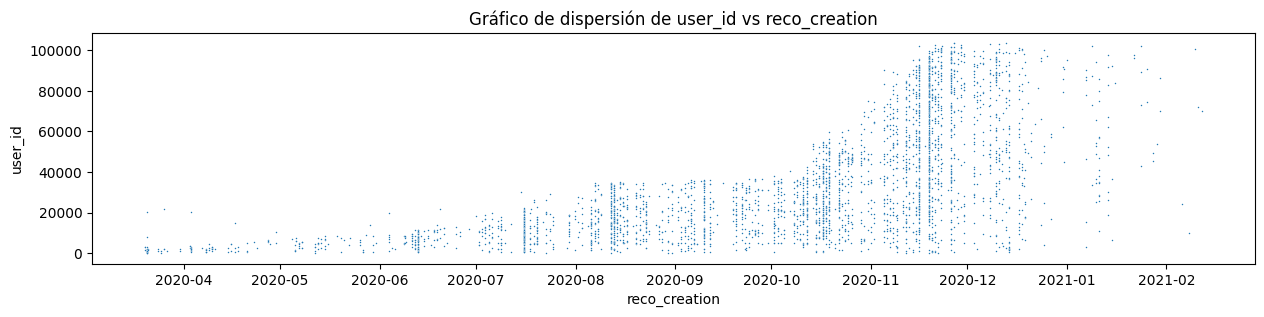

Gráfico de dispersión de user_id vs reco_last_update


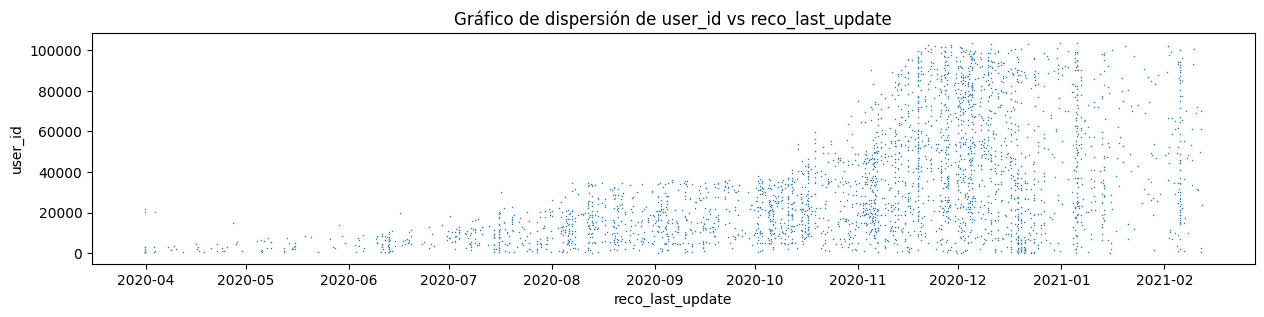

Gráfico de dispersión de moderated_at vs reimbursement_date


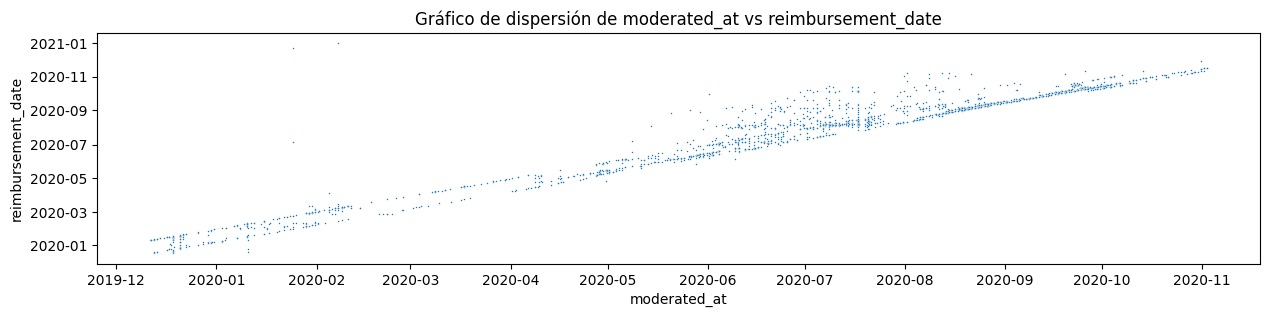

Gráfico de dispersión de moderated_at vs cash_request_received_date


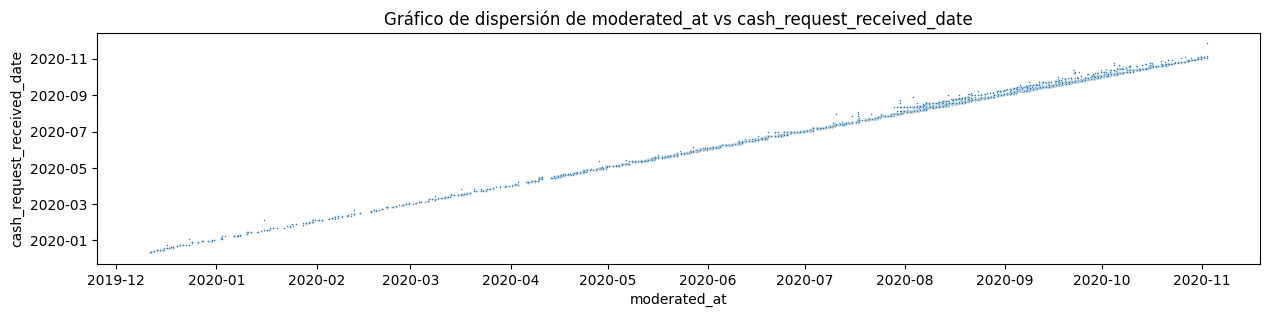

Gráfico de dispersión de moderated_at vs money_back_date


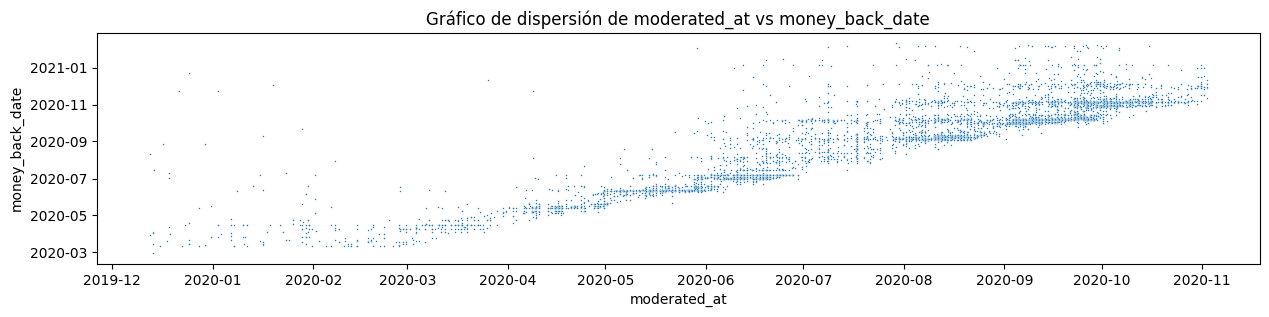

Gráfico de dispersión de moderated_at vs send_at


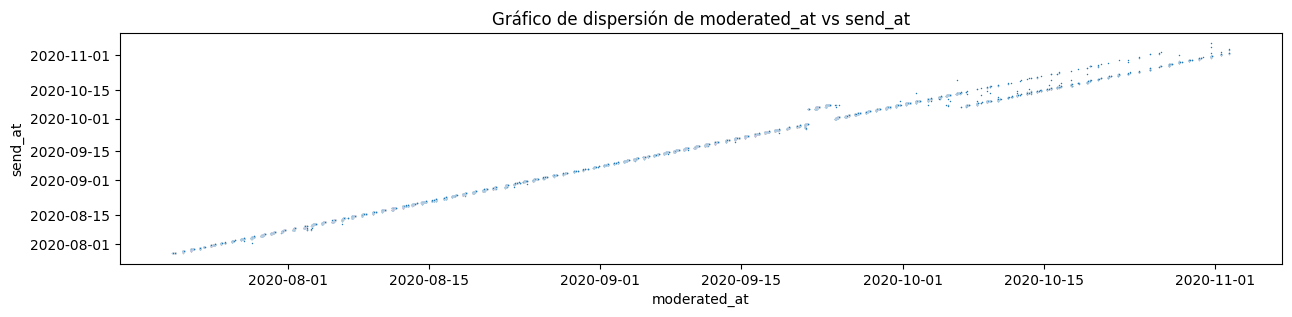

Gráfico de dispersión de moderated_at vs reco_creation


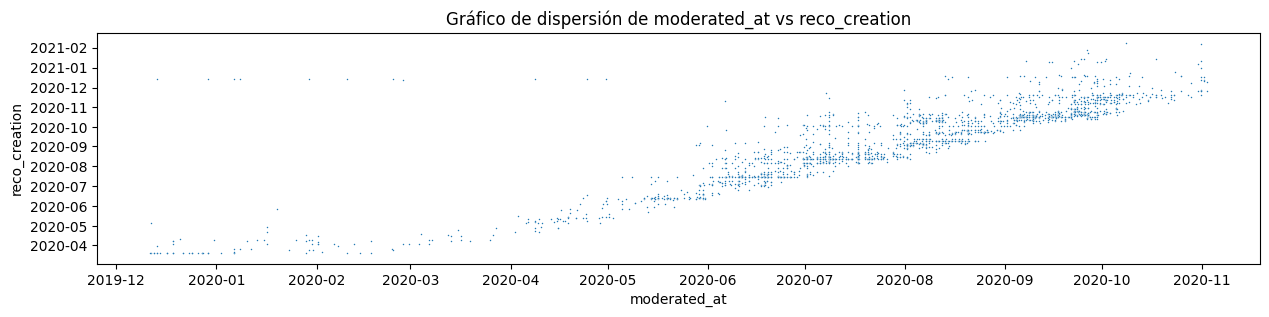

Gráfico de dispersión de moderated_at vs reco_last_update


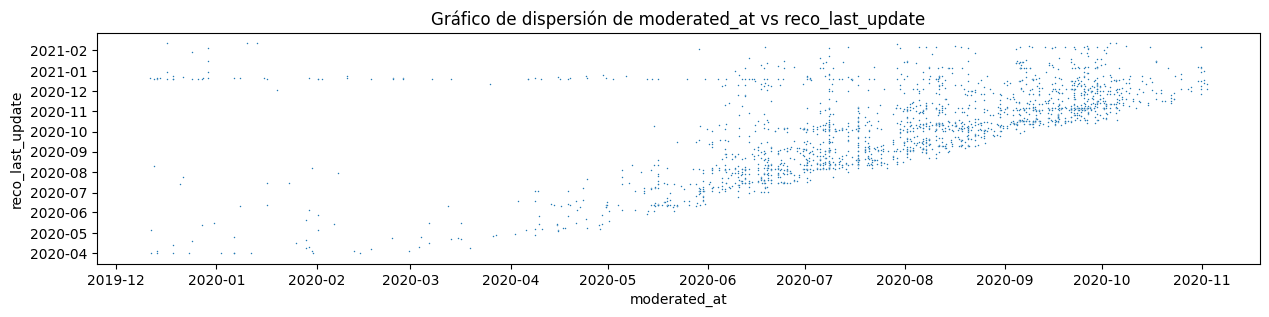

Gráfico de dispersión de reimbursement_date vs cash_request_received_date


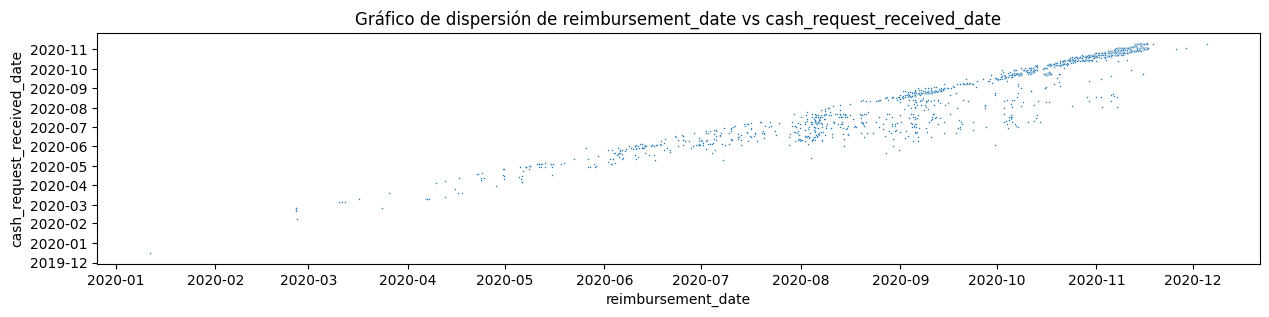

Gráfico de dispersión de reimbursement_date vs money_back_date


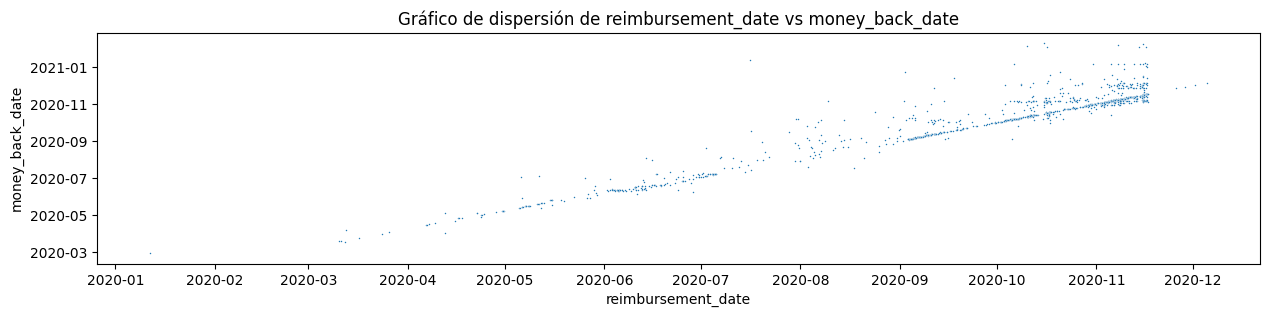

Gráfico de dispersión de reimbursement_date vs send_at


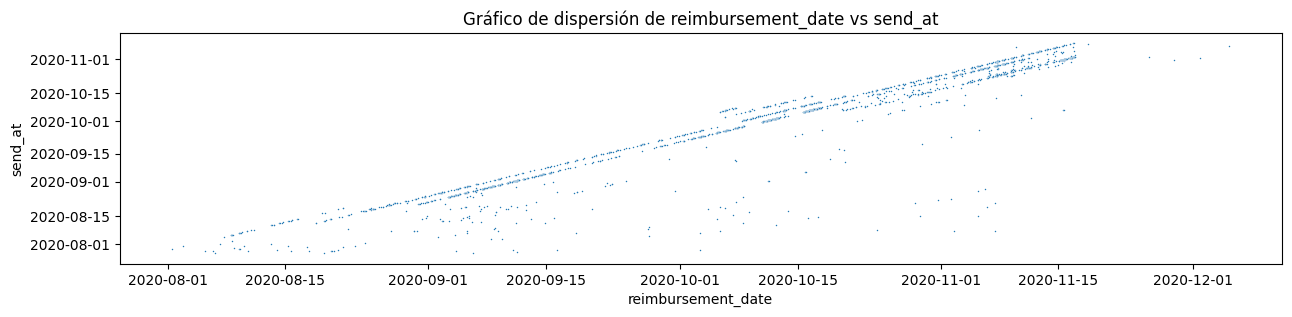

Gráfico de dispersión de reimbursement_date vs reco_creation


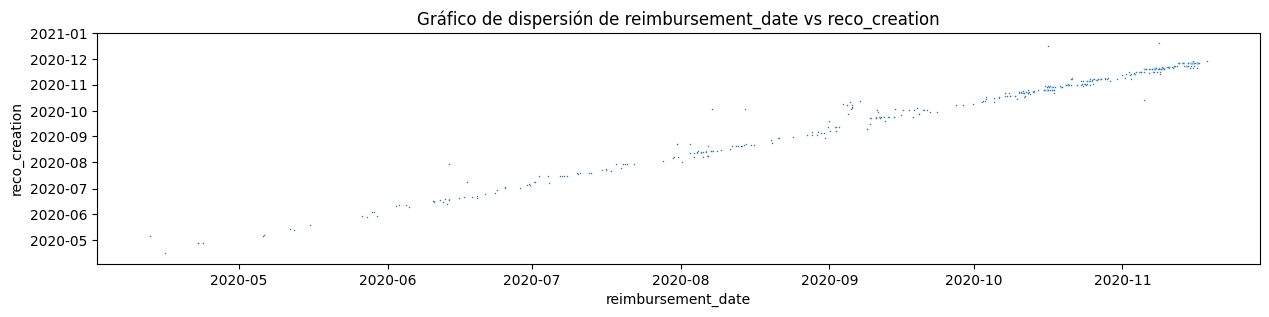

Gráfico de dispersión de reimbursement_date vs reco_last_update


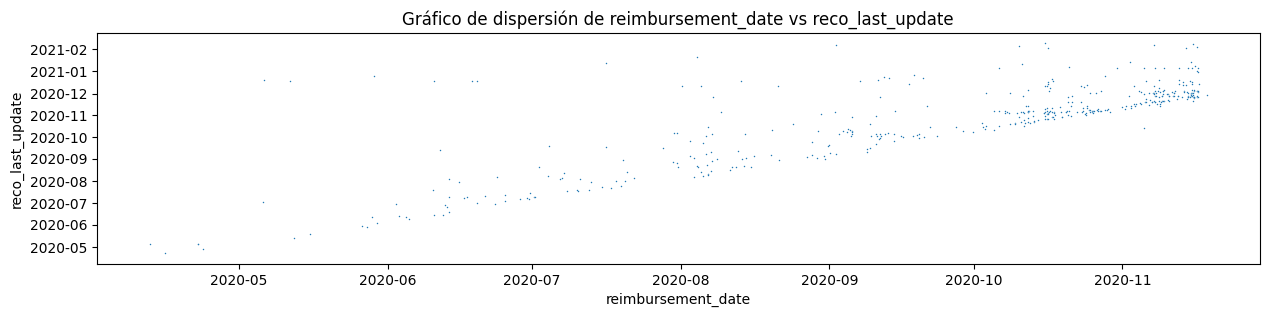

Gráfico de dispersión de cash_request_received_date vs money_back_date


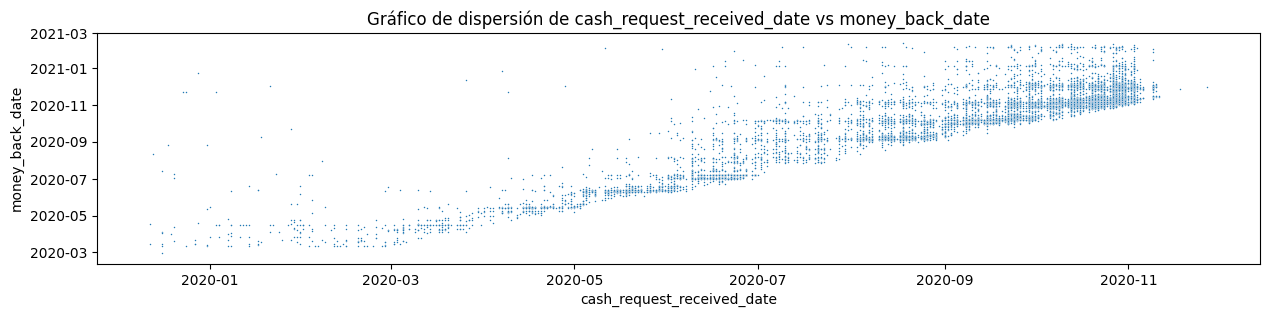

Gráfico de dispersión de cash_request_received_date vs send_at


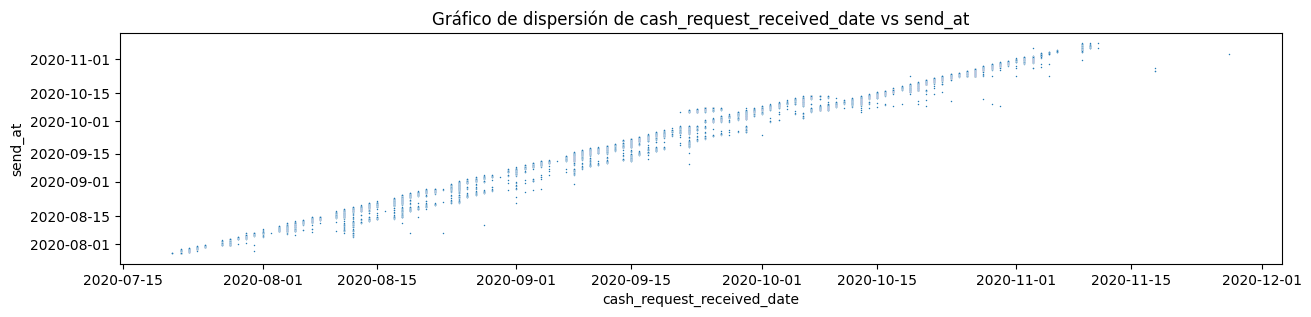

Gráfico de dispersión de cash_request_received_date vs reco_creation


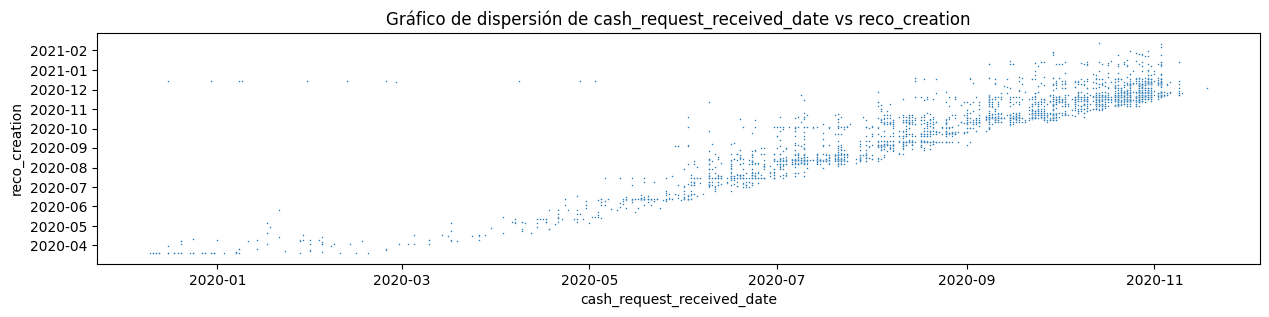

Gráfico de dispersión de cash_request_received_date vs reco_last_update


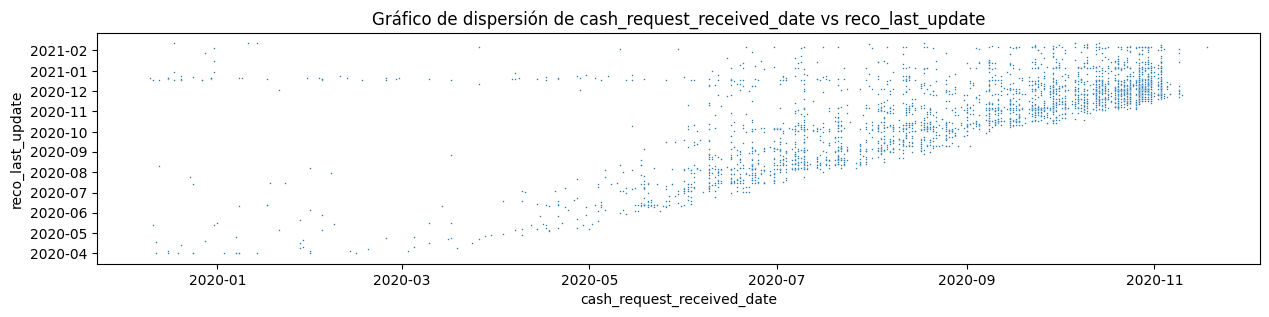

Gráfico de dispersión de money_back_date vs send_at


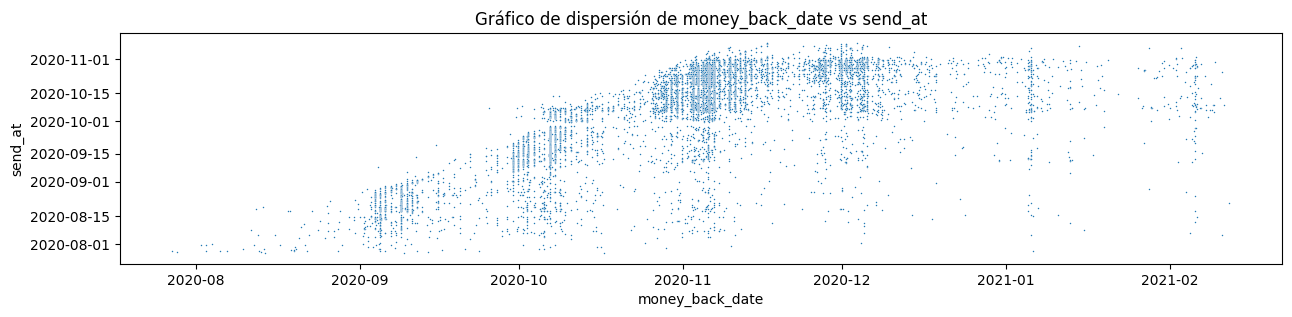

Gráfico de dispersión de money_back_date vs reco_creation


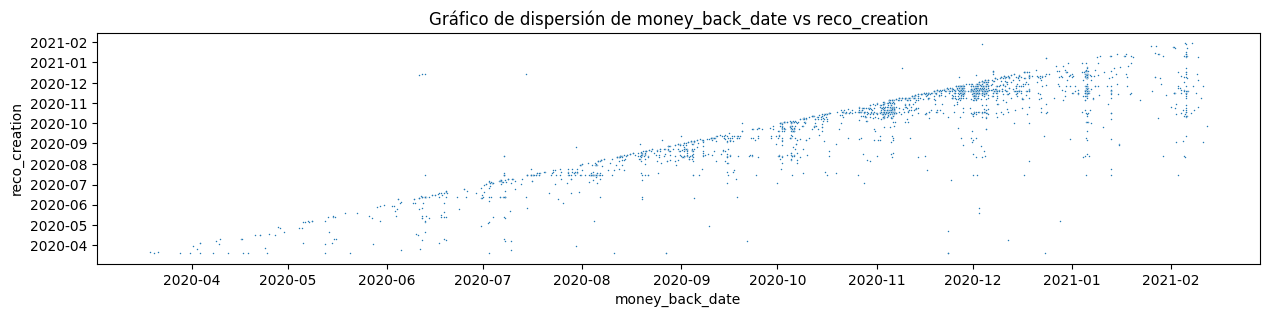

Gráfico de dispersión de money_back_date vs reco_last_update


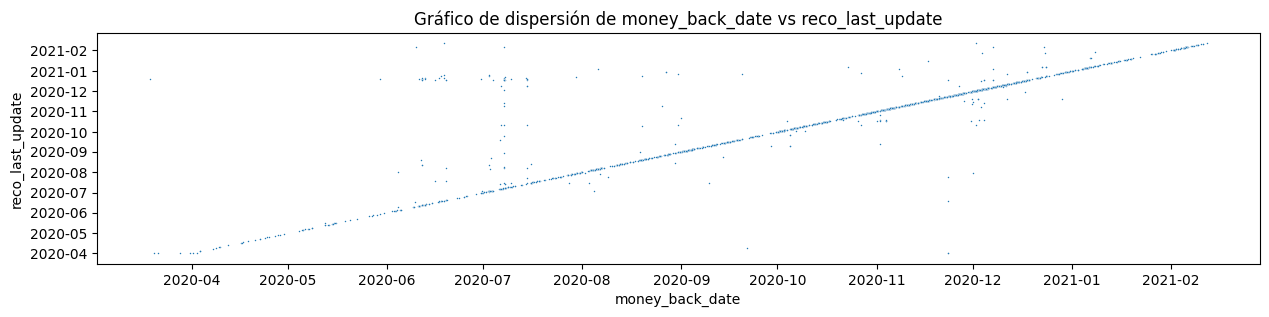

Gráfico de dispersión de send_at vs reco_creation


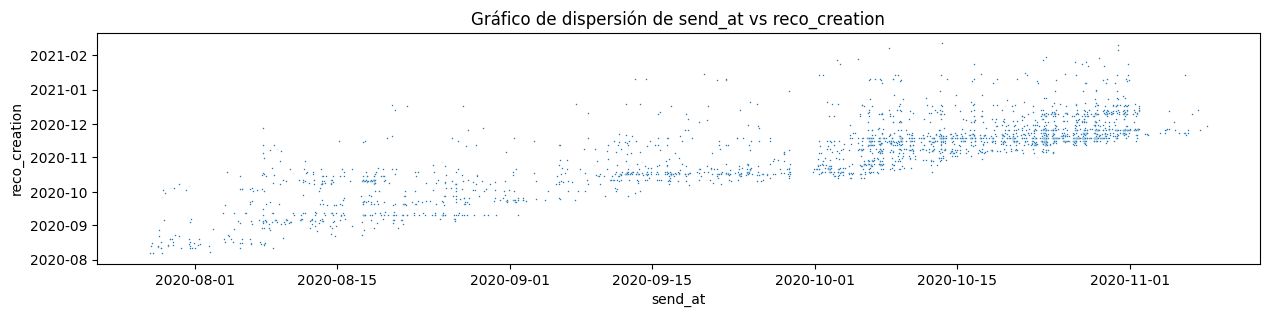

Gráfico de dispersión de send_at vs reco_last_update


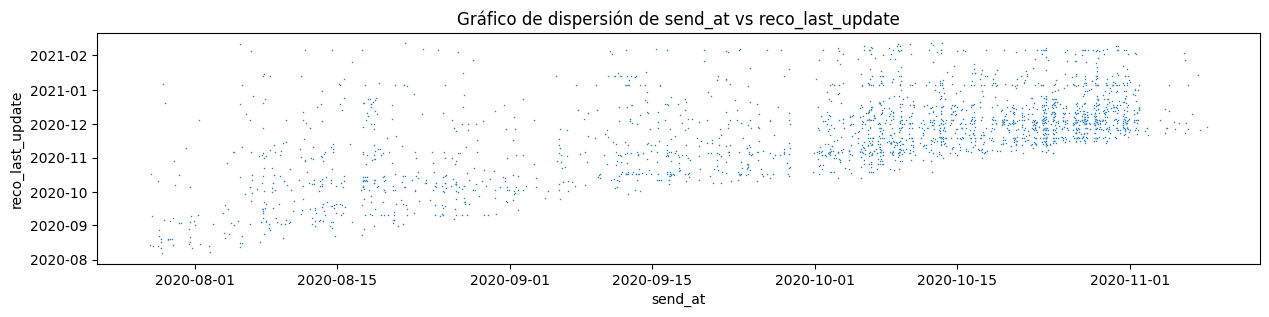

Gráfico de dispersión de reco_creation vs reco_last_update


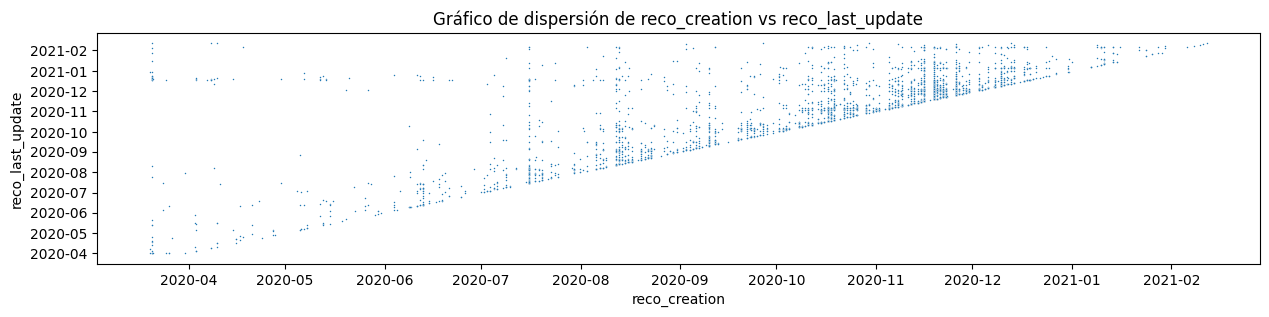

Observación: los importes más


In [197]:
# Genera gráficos de dispersión para todas las combinaciones de columnas numéricas

columnas_numericas=data.describe().columns.tolist()

for c1, c2 in itertools.combinations(columnas_numericas, 2):
    print(f'Gráfico de dispersión de {c1} vs {c2}')
    plt.figure(figsize=(15, 3))
    plt.title(f'Gráfico de dispersión de {c1} vs {c2}')
    if data[c1].dtype.kind != 'M' and data[c2].dtype.kind == 'M':
        t = c1
        c1 = c2
        c2 = t
    sns.scatterplot(data=data, x=c1, y=c2, marker='.', s=5)
    if data[c1].dtype.kind != 'M' and data[c2].dtype.kind != 'M':
        z = np.polyfit(data[c1], data[c2], 1)
        p = np.poly1d(z)
        plt.plot(data[c1],p(data[c1]),"r--")
        # plt.hexbin(data=data, x=c1, y=c2, gridsize=30, cmap='Blues')

    plt.show()

print('Observación: Ha habido un update masivo a finales 2020 en dos tandas, una el 11/20 para los creados hasta 06/20 y otra a finales de 12/20 para los creados desde el 06/20 (Gráfico de dispersión de created_at vs updated_at)')
print('Observación: Hubo un retraso de una semana en el envio de los creados el 20/09/21 (Gráfico de dispersión de created_at vs send_at)')

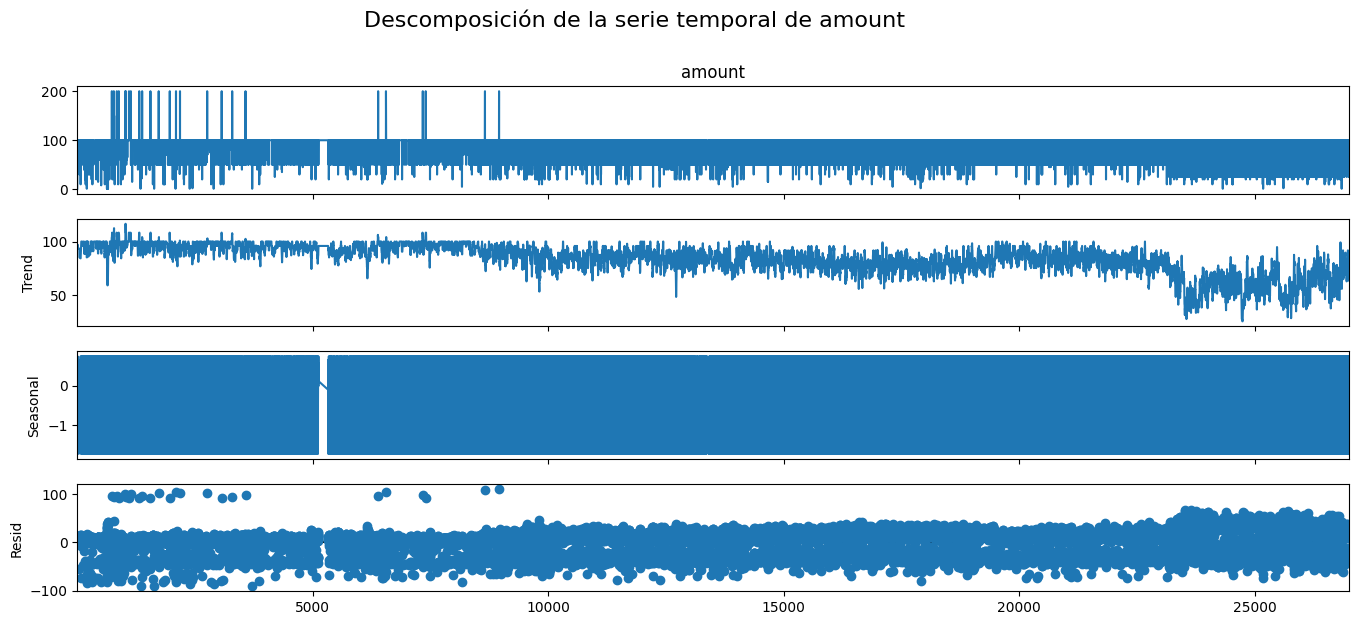

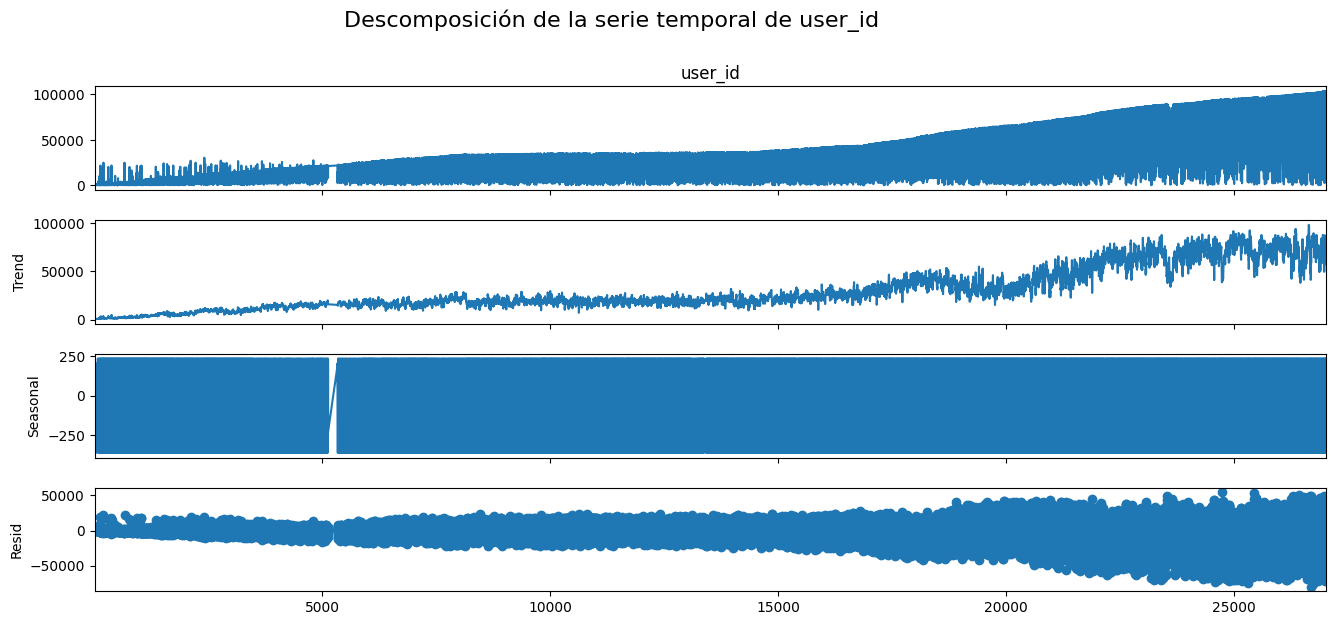

In [203]:
# Descomposición de series temporales para cada columna numérica individual
for c in columnas_numericas:
    if data[c].dtype.kind != 'M':
        # Crear una copia del DataFrame para trabajar
        data_copy = data[c].copy()
        # Verifica si hay valores faltantes y elimínalos o interpola
        if data_copy.isnull().any():
            data_copy = data_copy.interpolate() # Rellenar NaN con interpolación
        # Eliminar filas con valores faltantes
        data_copy = data_copy.dropna()
        # Verificar que no hay valores no finitos
        if not np.isfinite(data_copy).all():
            print(f'La columna {c} contiene valores no finitos, se omite la descomposición.')
            continue
        # Descomposición de la serie temporal
        descomposicion = seasonal_decompose(data_copy, model='additive', period=12)
        # Graficar la descomposición
        fig = descomposicion.plot()
        # Ajustar el tamaño de la figura con matplotlib
        plt.gcf().set_size_inches(15, 6)
        # Ajustar el título para que no se superponga
        fig.suptitle(f'Descomposición de la serie temporal de {c}', fontsize=16, y=1.05)
        plt.show()
 


## 2 Análisis de Cohortes Avanzado y la Extracción de Insights


El análisis de cohortes avanzado y la extracción de insights son componentes cruciales en el ámbit el análisis de datos y la toma de decisiones estratégicas en diversos campos,desde elmarketin igital hasta la gestión de productos y servicios.Ambos procesos permiten entender mejor el co mportamiento de los usuarios, identificar patrones significativos y tomar decisiones fundamentadas e atos. A continuación, se detallan algunas estrategias comunes para llevar a cabo estas prácticas:
### 2.1 Análisis de Cohortes Avanzado:
El análisis de cohortes se refiere a la agrupación de individuos que comparten una característic omún o que han experimentado un evento similar en un período específico de tiempo.El análisi vanzado de cohortes implica eluso de técnicas más sofisticadas para comprender mejor elcomportamiento de estos grupos a lo largo deltiempo y extraer insights valiosos.A continuación,s etallan técnicas y enfoques comunes:
1. **Refinamiento de Cohortes**
    - Segmentación adicional de cohortes: Divide los grupos en subconjuntos más específicos basados en características demográficas (edad, género, ubicación), comportamiento specíficos (frecuencia de compra, interacciones en línea) o patrones de uso (horarios d so, dispositivos utilizados).Esto permite una comprensión más profunda de los comportamientos y necesidades de diferentes grupos de usuarios.
    - Utilización de técnicas de clustering: Aplica algoritmos de agrupamiento par dentificar subgrupos dentro de las cohortes principales.Esto te permite descubrir patrones más complejos y segmentar los datos de manera más precisa,lo que facilita l ersonalización de estrategias y acciones.
2. **Análisis de Retención**
    - Seguimiento de la retención: Observa cómo cambia la cantidad de usuarios activo entro de cada cohorte a lo largo del tiempo.Esto te ayuda a comprender si los usuario ermanecen comprometidos con tu producto o servicio y a identificar posibles problema e retención.
    - Identificación de factores de retención: Examina qué factores influyen en la retención de los usuarios (como la calidad delproducto,la experiencia delusuario o la romociones).Luego,desarrolla estrategias para mejorar la retención basadas en esto allazgos,lo que puede incluir mejoras en la experiencia delusuario,ofertas especiale  programas de fidelización.
3. **Cohortes Dinámicas**
    - Creación de cohortes dinámicas: Actualiza continuamente las cohortes para refleja os cambios en el comportamiento del usuario o las características del producto.Esto t ermite mantener un seguimiento preciso de la evolución del rendimiento a lo largo de iempo y adaptar tus estrategias en consecuencia.
    - Uso de modelos predictivos: Implementa modelos que puedan predecir elcomportamiento futuro de las cohortes en función de datos históricos y variables clave.Esto t yuda a anticipar tendencias y tomar decisiones proactivas, como la personalización d fertas o la optimización de la distribución de recursos.
4. **Análisis de Recurrencia**
    - Estudio de la frecuencia de retorno: Analiza qué tan a menudo los usuarios regresa espués de su primera interacción con tu producto o servicio.Esto te permite entende a lealtad del cliente y su propensión a continuar utilizando tu oferta.
    - Identificación de patrones recurrentes: Busca patrones en el comportamiento de lo suarios que indican una alta probabilidad de regreso, como la frecuencia de compra o l articipación en actividades específicas.Estos patrones pueden ser clave para desarrolla strategias efectivas de retención y compromiso.
5. **Análisis de Comportamiento**
    - Seguimiento del comportamiento individual: Examina cómo se comportan lo suarios dentro de cada cohorte a lo largo deltiempo. Esto te ayuda a identifica endencias, cambios de comportamiento y momentos clave en el ciclo de vida del usuario,
1 o que puede informar la optimización de la experiencia del usuario y la personalizació e las estrategias de marketing.
    - Identificación de patrones y puntos de inflexión: Busca momentos en los que e omportamiento de los usuarios cambie significativamente, como la adopción de nueva aracterísticas o la disminución de la actividad.Estos puntos de inflexión pueden se portunidades para la intervención y la mejora continua del producto o servicio.
### 2.2 Extracción de Insights:
La extracción de insights implica el proceso de identificar y comprender información significativa y útil a partir de los datos analizados.A continuación, se detallan algunas estrategias comunes par xtraer insights del análisis de cohortes:
1. **Segmentación Avanzada**
    - Segmentación detallada de las cohortes: Divide los grupos en segmentos más específicos basados en características compartidas o comportamientos similares.Esto t ermite personalizar tus estrategias para satisfacer las necesidades únicas de cada segmento, lo que puede mejorar la efectividad de tus acciones y campañas.
    - Personalización de estrategias: Utiliza los segmentos identificados para adaptar tu strategias de marketing,comunicación y experiencia delusuario, lo que aumenta l elevancia y la efectividad de tus acciones y mejora la satisfacción del cliente.
2. **Identificación de Tendencias**
    - Detección de tendencias a lo largo del tiempo: Analiza cómo evolucionan la étricas clave (como la retención o el compromiso) dentro de cada cohorte con el tiempo.
Esto te ayuda a identificar patrones y entender cómo ciertos eventos o cambios afecta l comportamiento de los usuarios, lo que puede informar decisiones estratégicas futuras.
    - Análisis de eventos específicos: Examina cómo eventos como lanzamientos de productos, campañas de marketing o cambios en el diseño impactan en el comportamient e las cohortes.Esto te proporciona información valiosa para la planificación futura  a evaluación del éxito de tus iniciativas.
3. **Predicción y Modelado**
    - Utilización de modelos predictivos: Implementa modelos que puedan predecir e omportamiento futuro de las cohortes en función de datos históricos y variables clave.
Esto te ayuda a anticipar tendencias y tomar decisiones informadas sobre estrategia uturas, lo que puede aumentar la eficiencia y el éxito de tus acciones.
    - Evaluación de impacto: Evalúa el impacto potencialde cambios en productos,servicios o estrategias antes de implementarlos.Esto te permite tomar decisiones má ólidas y minimizar los riesgos asociados con nuevas iniciativas, lo que puede mejorar l entabilidad y la satisfacción del cliente a largo plazo.
4. **Benchmarking y Comparación**
    - Comparación del rendimiento: Compara el rendimiento de diferentes cohortes  egmentos de usuarios para identificar áreas de fortaleza y oportunidades de mejora.
Esto te ayuda a entender tu posición en el mercado y a identificar estrategias par iferenciarte y destacarte entre la competencia.
    - Benchmarking contra competidores: Compara tus métricas con las de tus competidores o estándares de la industria para entender tu posición en el mercado y encontra portunidades para diferenciarte.Esto te proporciona información valiosa sobre la ejores prácticas y te ayuda a identificar áreas de mejora y oportunidades de crec1 miento.
5. **Acciones Estratégicas**
    - Desarrollo de estrategias específicas: Utiliza los insights obtenidos para desarrolla strategias específicas destinadas a mejorar la retención, el compromiso y el crecimient e tu negocio.Esto puede incluir cambios en productos o servicios, ajustes en la estrategia de marketing o mejoras en la experiencia del cliente.
    - Evaluación continua: Evalúa regularmente la efectividad de tus estrategias a travé el análisis de cohortes en curso y realiza ajustes según sea necesario para optimizar lo esultados a lo largo del tiempo.Esto te permite adaptarte a los cambios en el mercad  mantener una ventaja competitiva a largo plazo.


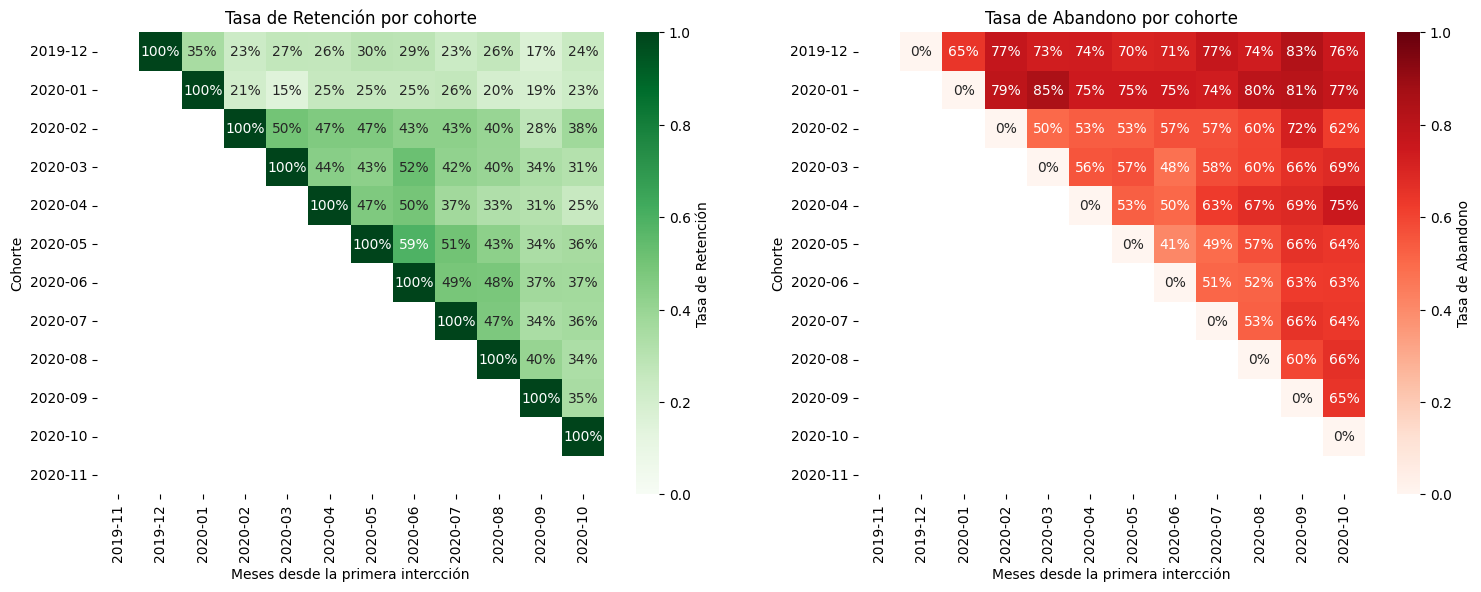

In [268]:
def retention_rate_monthly(cr, field_id, field_date, delete_last=True, title='por cohorte'):
    # Crear columna 'Mes' indicando el mes de cada intercción
    cr['Mes'] = cr[field_date].dt.to_period('M')
    # Crear columna 'Cohorte' que indica el mes de la primera intercción de cada id
    cr['Cohorte'] = cr.groupby(field_id)[field_date].transform('min').dt.to_period('M')
    # Calcular el número inicial de field_id únicos en cada cohorte
    cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_id_Iniciales=(field_id, 'nunique')).reset_index()
    # Calcular la cantidad de field_id únicos en cada cohorte para cada mes
    cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_id=(field_id, 'nunique')).reset_index()
    # Calcular la tasa de retención de field_id (field_id únicos por cohorte en cada mes / field_id iniciales de la cohorte) 
    retention = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes',values='Num_id')
    retention = retention.div(cohort_sizes_initial.set_index('Cohorte')['Num_id_Iniciales'], axis=0)
    retention = retention.iloc[1:, :-1] if delete_last else retention
    # Calcular la tasa de abandono de field_id (1 - tasa de retención)
    churn = 1 - retention

    if retention.empty:
        print(f'No existen registros para {field_id} '+ title)
        return 0

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Visualizar la tasa de retención de field_id usando un mapa de calor
    axs[0].set_title(f'Tasa de Retención ' + title)
    sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'}, ax=axs[0])
    axs[0].set_xlabel('Meses desde la primera intercción')
    axs[0].set_ylabel('Cohorte')

    # Visualizar la tasa de abandono de field_id usando un mapa de calor
    axs[1].set_title(f'Tasa de Abandono ' + title)
    sns.heatmap(data=churn, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'}, ax=axs[1])
    axs[1].set_xlabel('Meses desde la primera intercción')
    axs[1].set_ylabel('Cohorte')
    plt.show()

retention_rate_monthly(data.copy(), 'user_id', 'created_at')

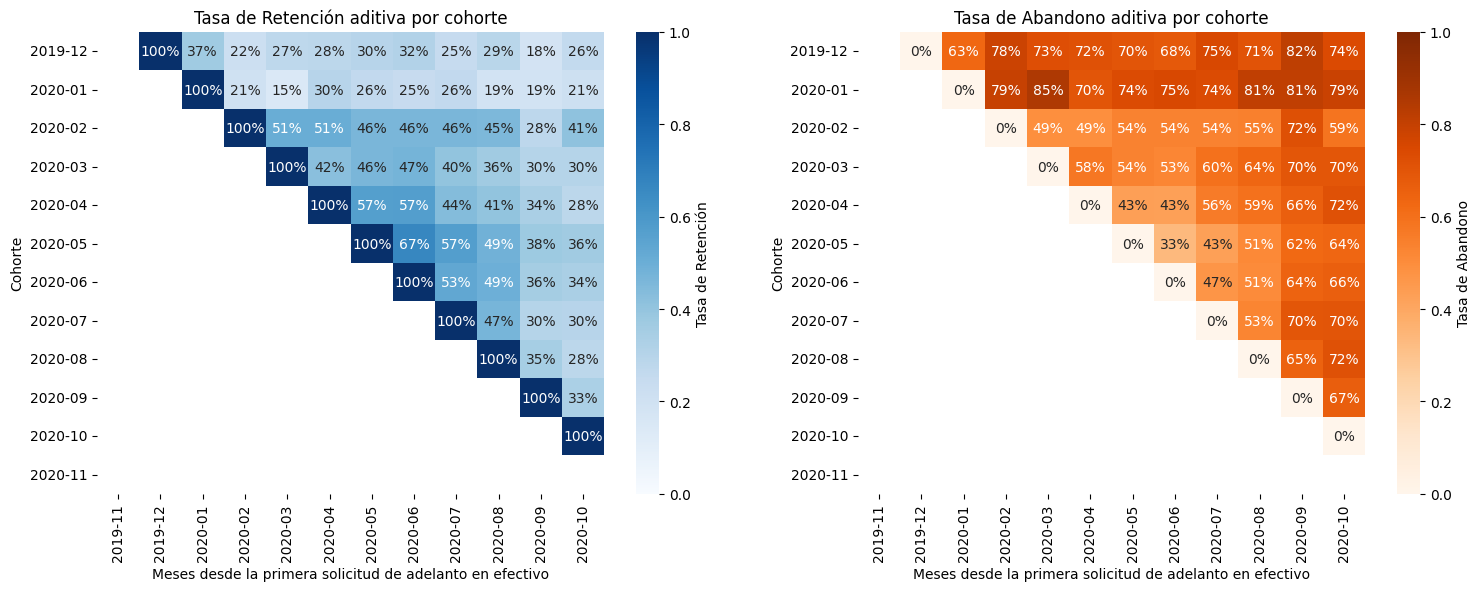

In [275]:
def retention_rate_solicit_monthly(cr, field_id, field_date, delete_last=True, title='por cohorte'):

    # Crear columna 'Mes' indicando el mes de cada intercción
    cr['Mes'] = cr[field_date].dt.to_period('M')
    # Crear columna 'Cohorte' que indica el mes de la primera intercción de cada id
    cr['Cohorte'] = cr.groupby(field_id)[field_date].transform('min').dt.to_period('M')
    # Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
    cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=(field_id, 'count')).reset_index()
    # Calcular el número inicial de solicitudes de adelanto de efectivo en cada cohorte
    cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes':'Num_Solicitudes_Iniciales'})
    # Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cada mes / solicitudes iniciales de la cohorte)
    retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Solicitudes')
    retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
    retention_cash = retention_cash.iloc[1:, :-1] if delete_last else retention_cash

    # Calcular la tasa de abandono de solicitudes (1 - tasa de retención de solicitudes)
    churn_cash = 1 - retention_cash

    if retention_cash.empty:
        print(f'No existen registros para {field_id} '+ title)
        return 0
        
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Visualizar la tasa de retención de solicitudes usando un mapa de calor
    axs[0].set_title('Tasa de Retención aditiva '+title)
    sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Blues', cbar_kws={'label': 'Tasa de Retención'}, ax=axs[0])
    axs[0].set_xlabel('Meses desde la primera solicitud de adelanto en efectivo')
    axs[0].set_ylabel('Cohorte')

    # Visualizar la tasa de abandono de solicitudes usando un mapa de calor
    axs[1].set_title('Tasa de Abandono aditiva '+title)
    sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'}, ax=axs[1])
    axs[1].set_xlabel('Meses desde la primera solicitud de adelanto en efectivo')
    axs[1].set_ylabel('Cohorte')
    plt.show()

retention_rate_solicit_monthly(data.copy(), 'user_id', 'created_at')

user_id únicos con status = canceled: 32
user_id en otro registro con status = canceled: 64


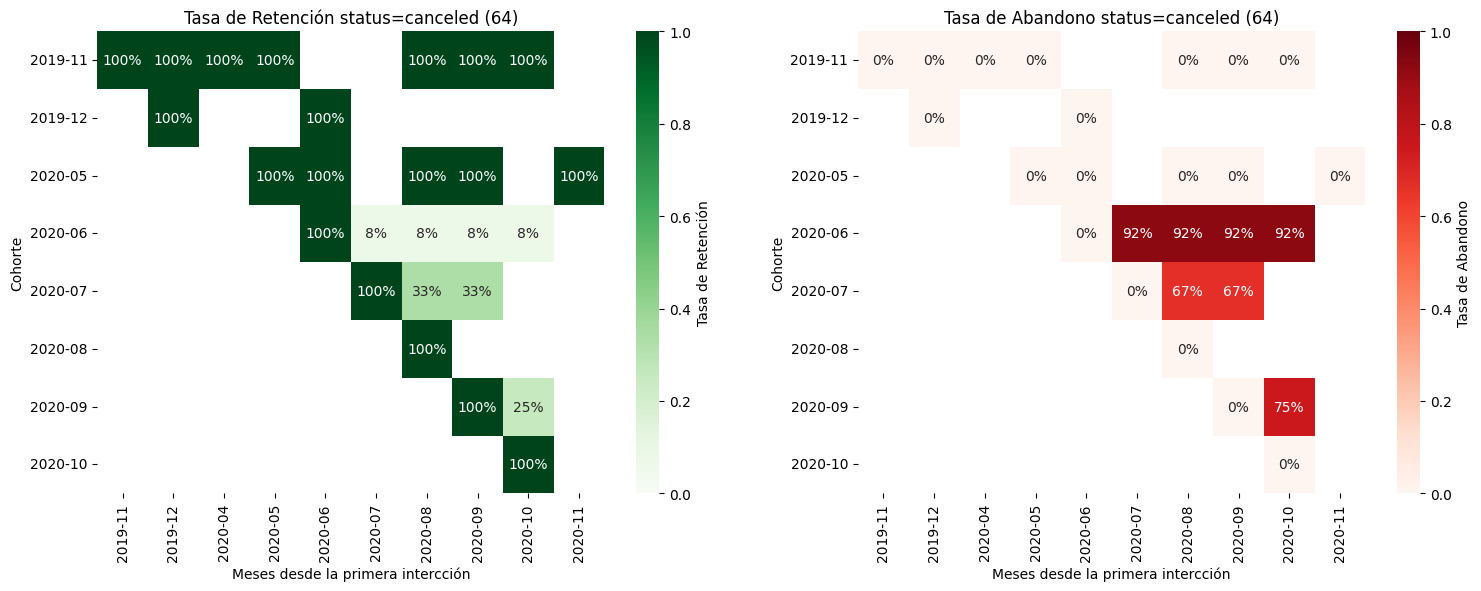

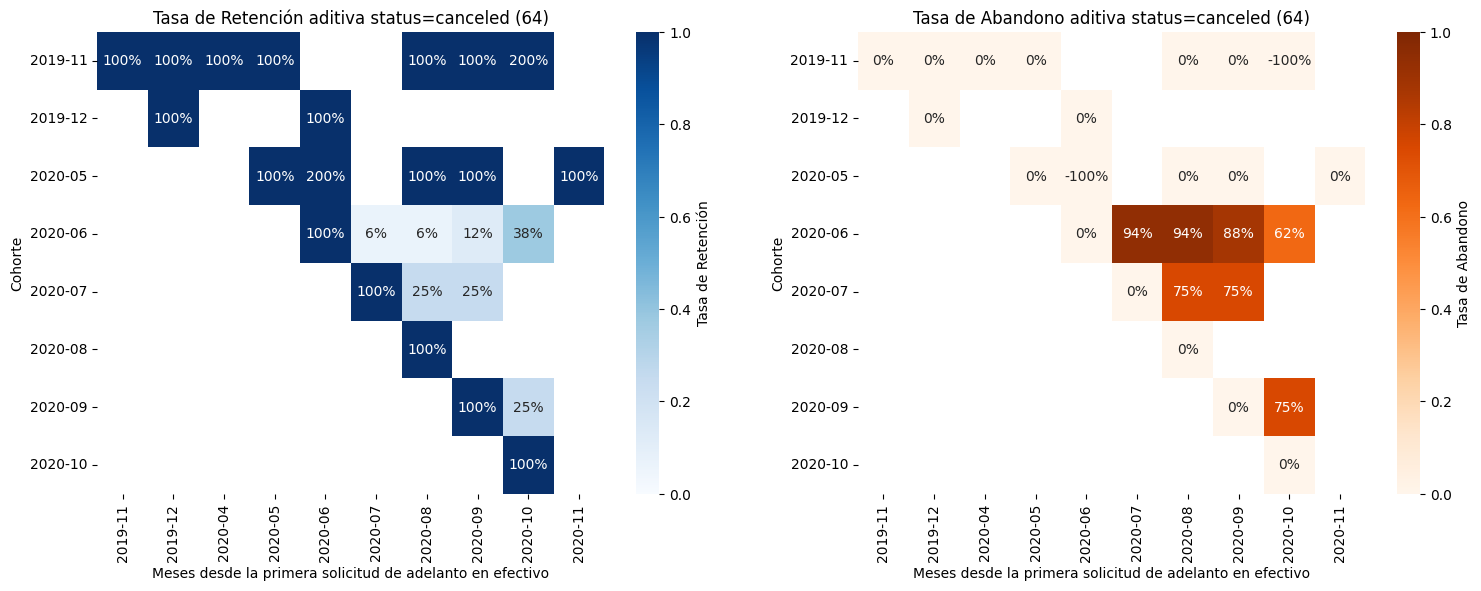

user_id únicos con status = money_back: 6
user_id en otro registro con status = money_back: 31


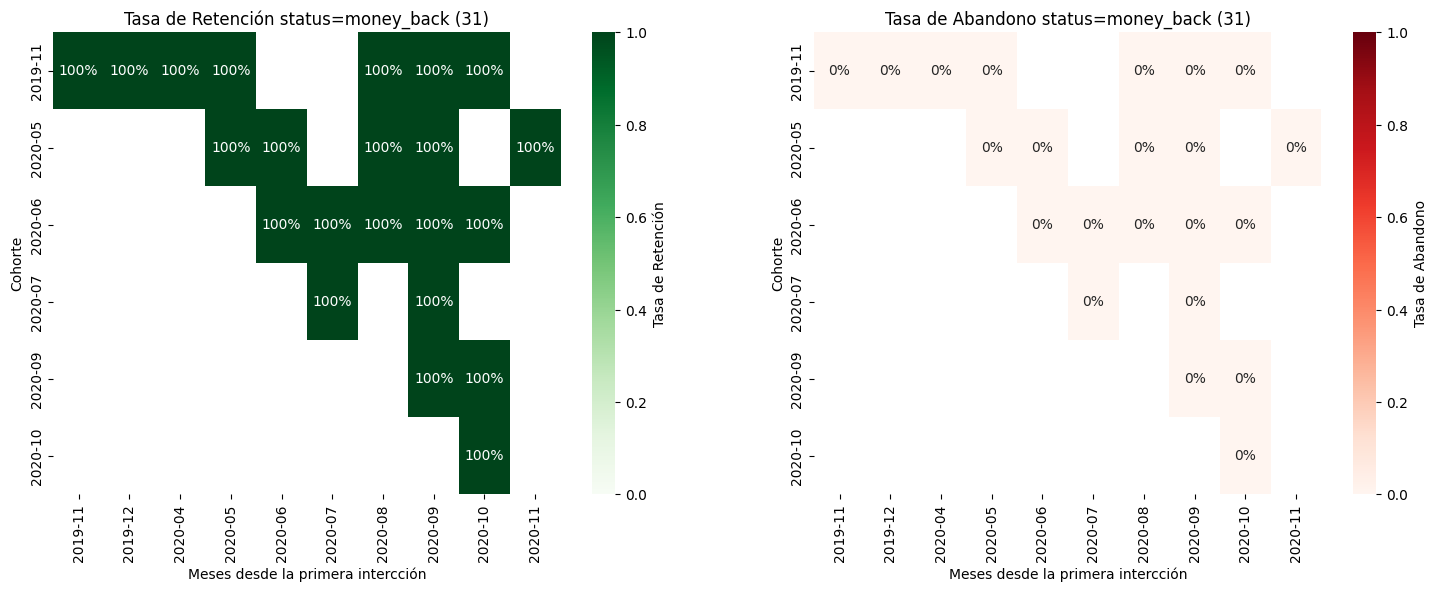

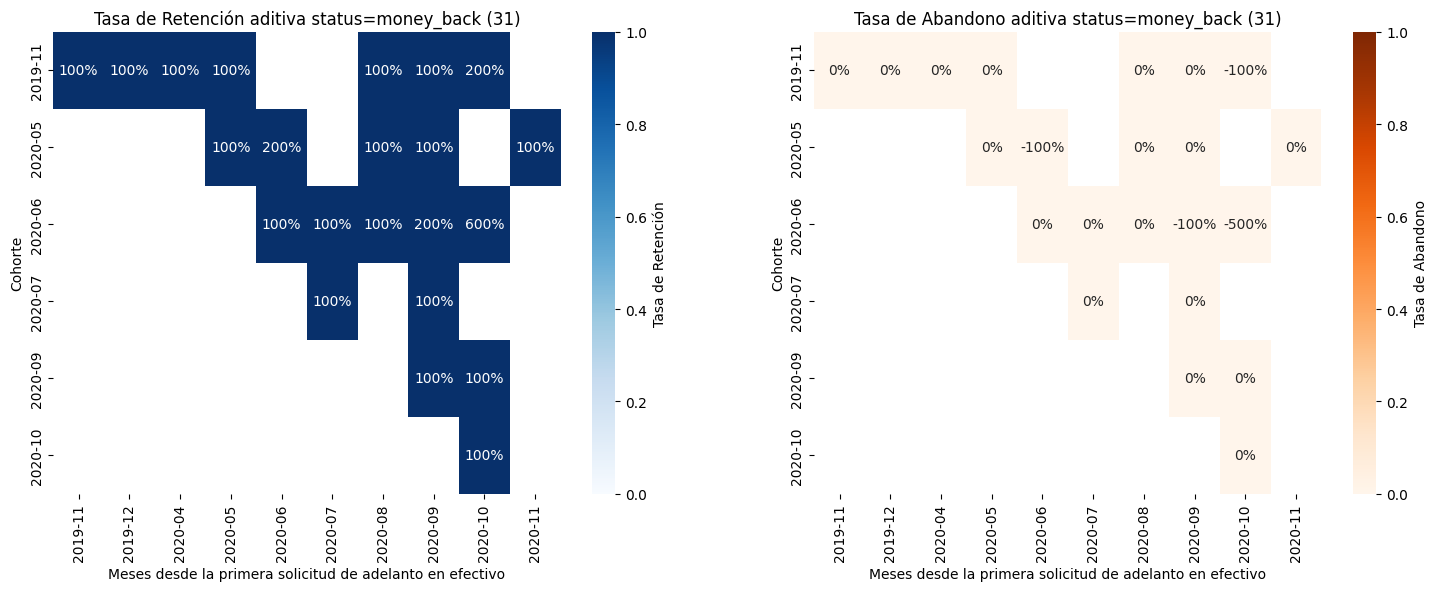

user_id únicos con status = rejected: 1
user_id en otro registro con status = rejected: 8


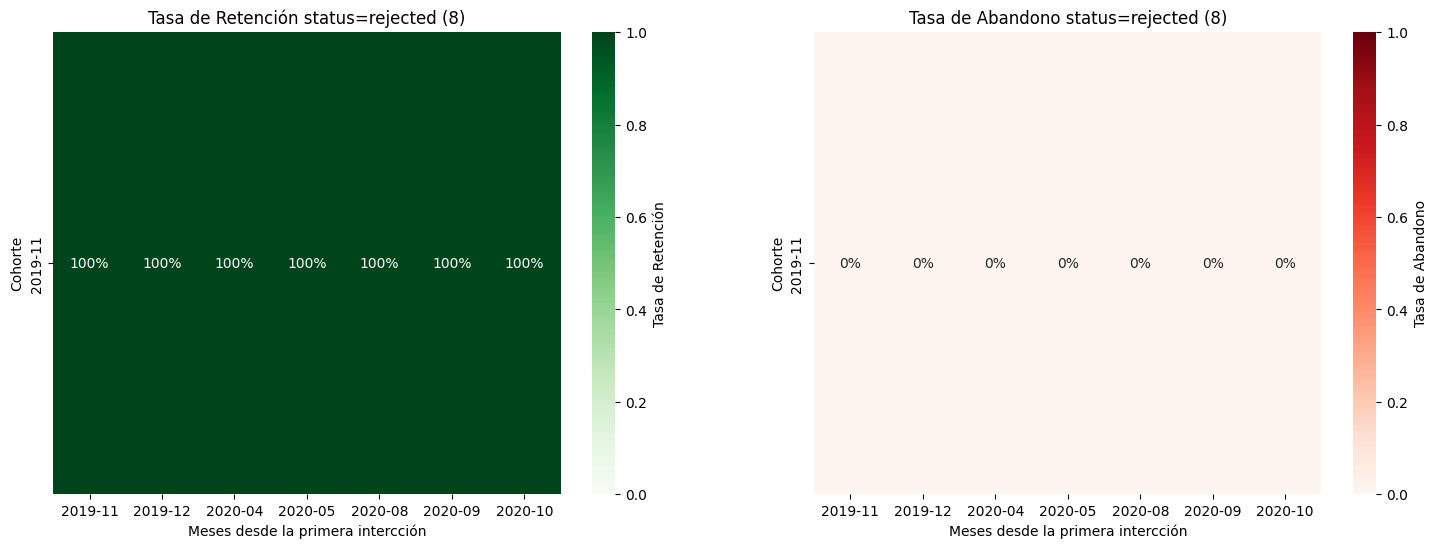

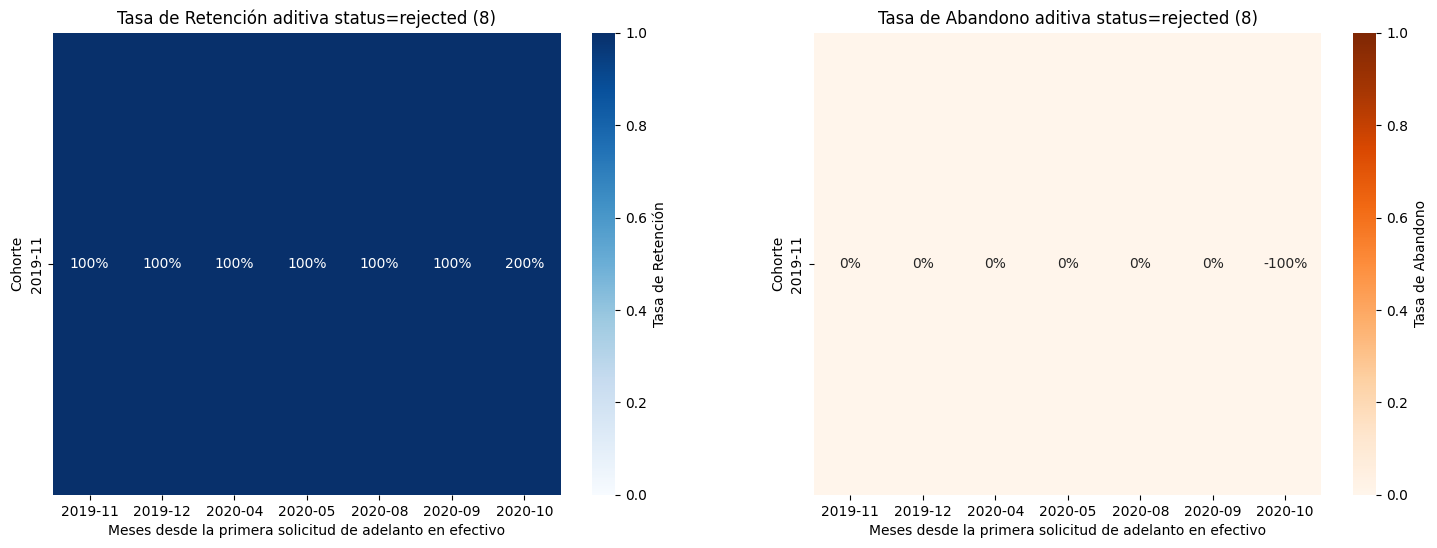

user_id únicos con status = direct_debit_rejected: 0
user_id en otro registro con status = direct_debit_rejected: 0
user_id únicos con status = direct_debit_sent: 0
user_id en otro registro con status = direct_debit_sent: 0
user_id únicos con status = active: 0
user_id en otro registro con status = active: 0
user_id únicos con status = transaction_declined: 0
user_id en otro registro con status = transaction_declined: 0
user_id únicos con transfer_type = regular: 4815
user_id en otro registro con transfer_type = regular: 15190


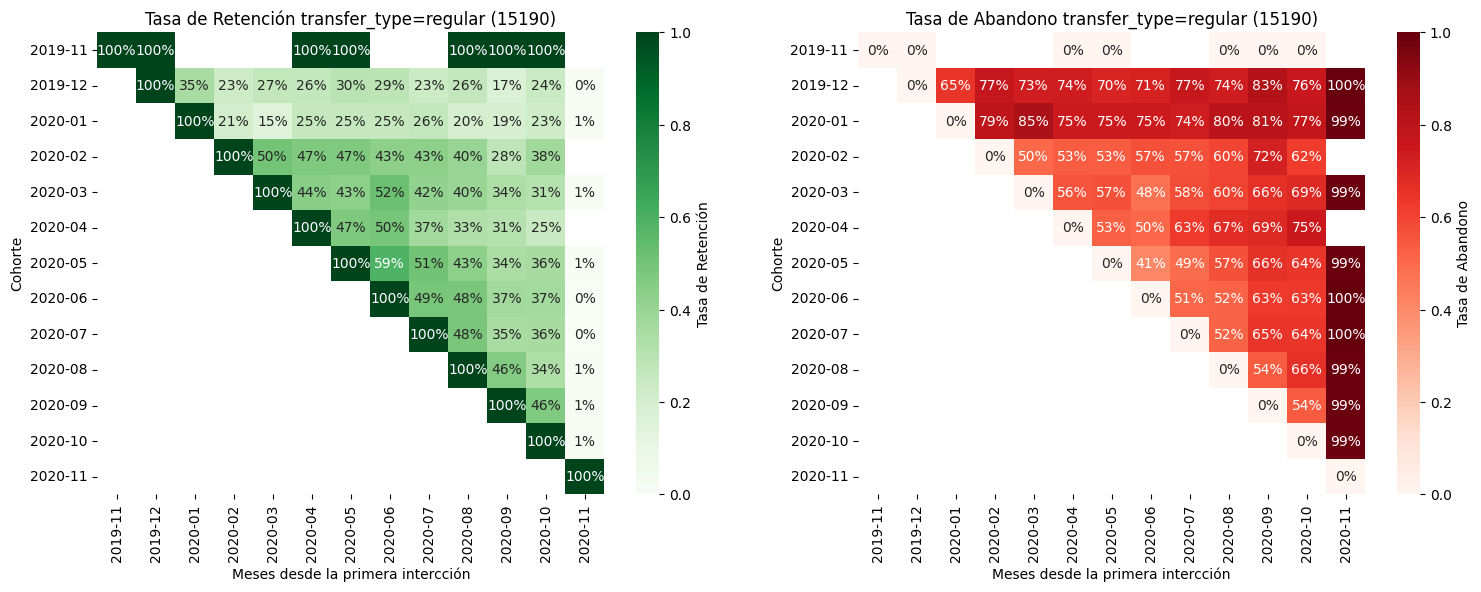

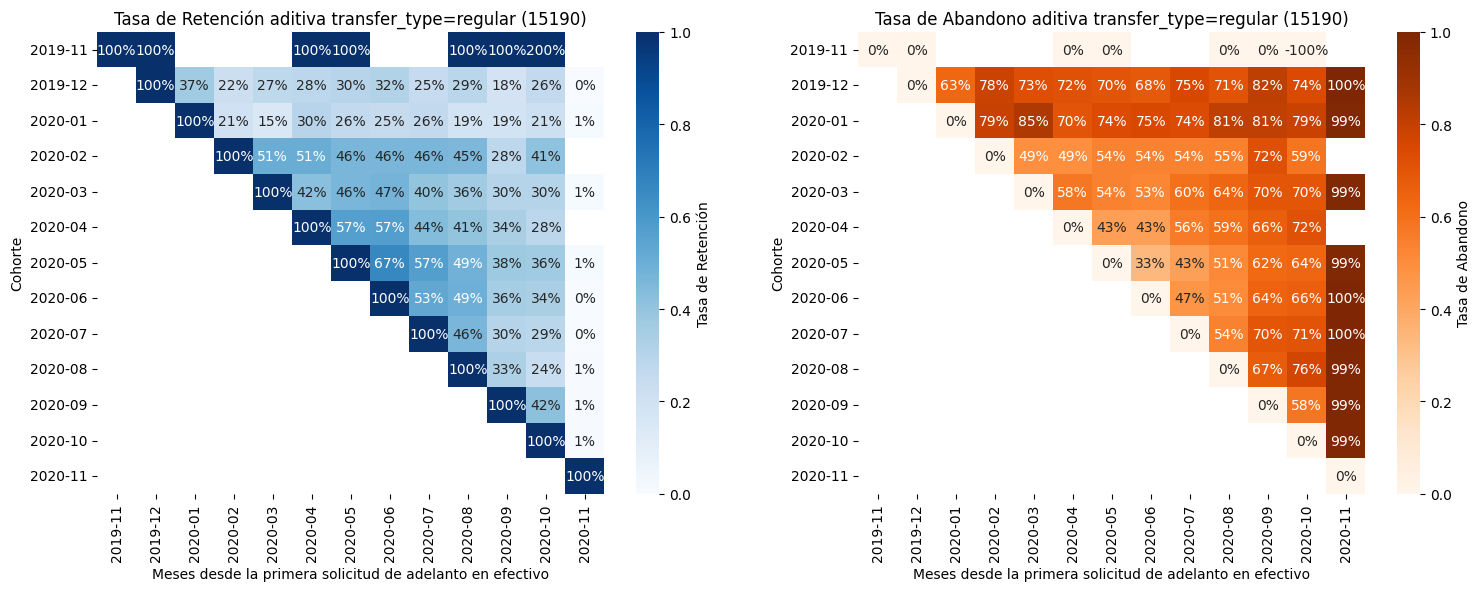

user_id únicos con transfer_type = instant: 2540
user_id en otro registro con transfer_type = instant: 11167


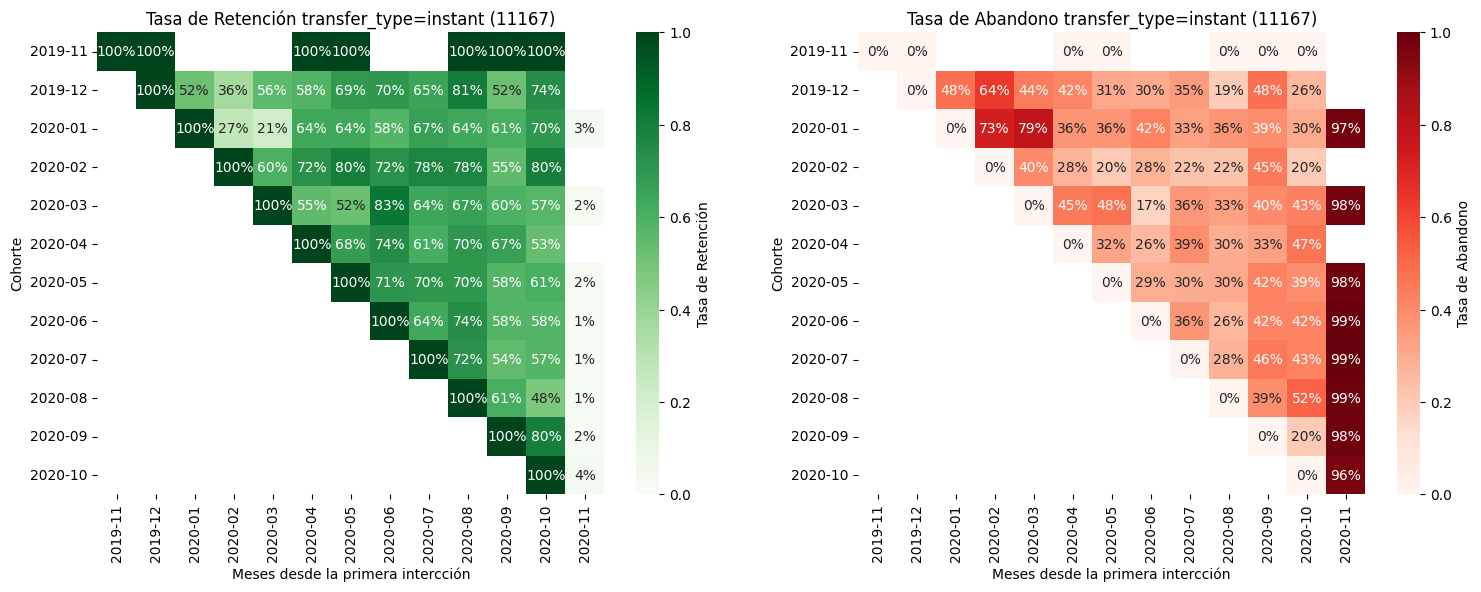

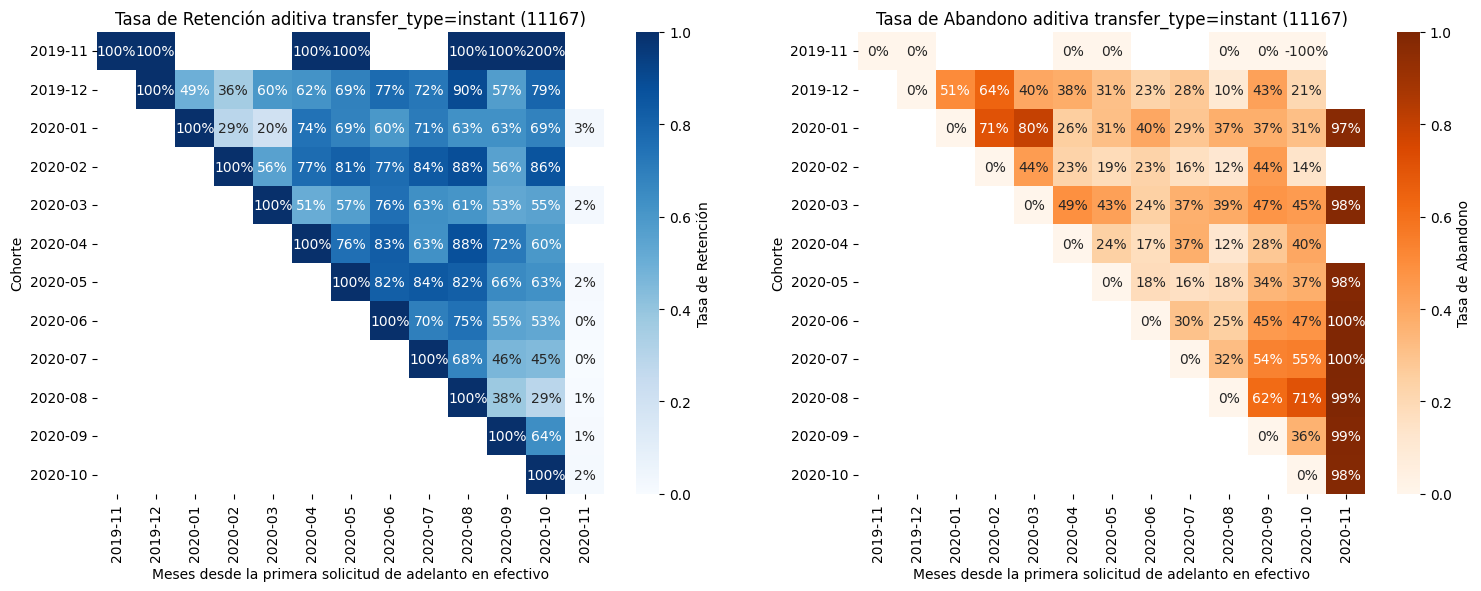

user_id únicos con recovery_status = nan: 0
user_id en otro registro con recovery_status = nan: 0
user_id únicos con recovery_status = pending: 0
user_id en otro registro con recovery_status = pending: 0
user_id únicos con recovery_status = completed: 0
user_id en otro registro con recovery_status = completed: 0
user_id únicos con recovery_status = pending_direct_debit: 0
user_id en otro registro con recovery_status = pending_direct_debit: 0
user_id únicos con recovery_status = cancelled: 0
user_id en otro registro con recovery_status = cancelled: 0
Observación: La tasa de retención de los clientes que tienen transferencias instantaneas es superior los que tienen regular (user_id en otro registro con transfer_type = instant: 11167)


In [270]:
def category_cohort(df, cohort_column, id_column, date_column):
    for cohort_value in df[cohort_column].unique():
        cohort_id = df[df[cohort_column] == cohort_value][id_column].unique()
        print(f'{id_column} únicos con {cohort_column} = {cohort_value}: {len(cohort_id)}')
        df = df[df[id_column].isin(cohort_id)]
        print(f'{id_column} en otro registro con {cohort_column} = {cohort_value}: {len(df)}')
        if len(df) > 0 :
            retention_rate_monthly(df, id_column, date_column, False, f'{cohort_column}={cohort_value} ({len(df)})')
            retention_rate_solicit_monthly(df, id_column, date_column, False, f'{cohort_column}={cohort_value} ({len(df)})')

for c in data.columns.tolist():
    if c not in columnas_numericas:
        category_cohort(data.copy(), c, 'user_id', 'created_at')
        
print('Observación: La tasa de retención de los clientes que tienen transferencias instantaneas es superior los que tienen regular (user_id en otro registro con transfer_type = instant: 11167)')

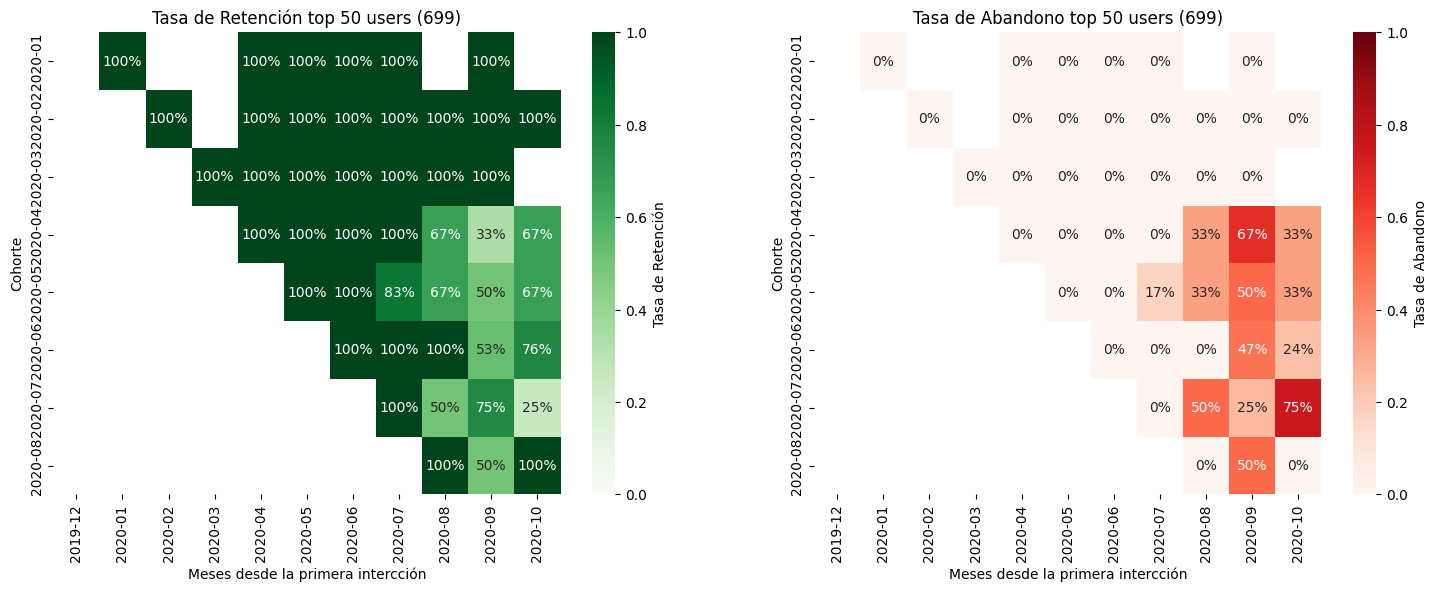

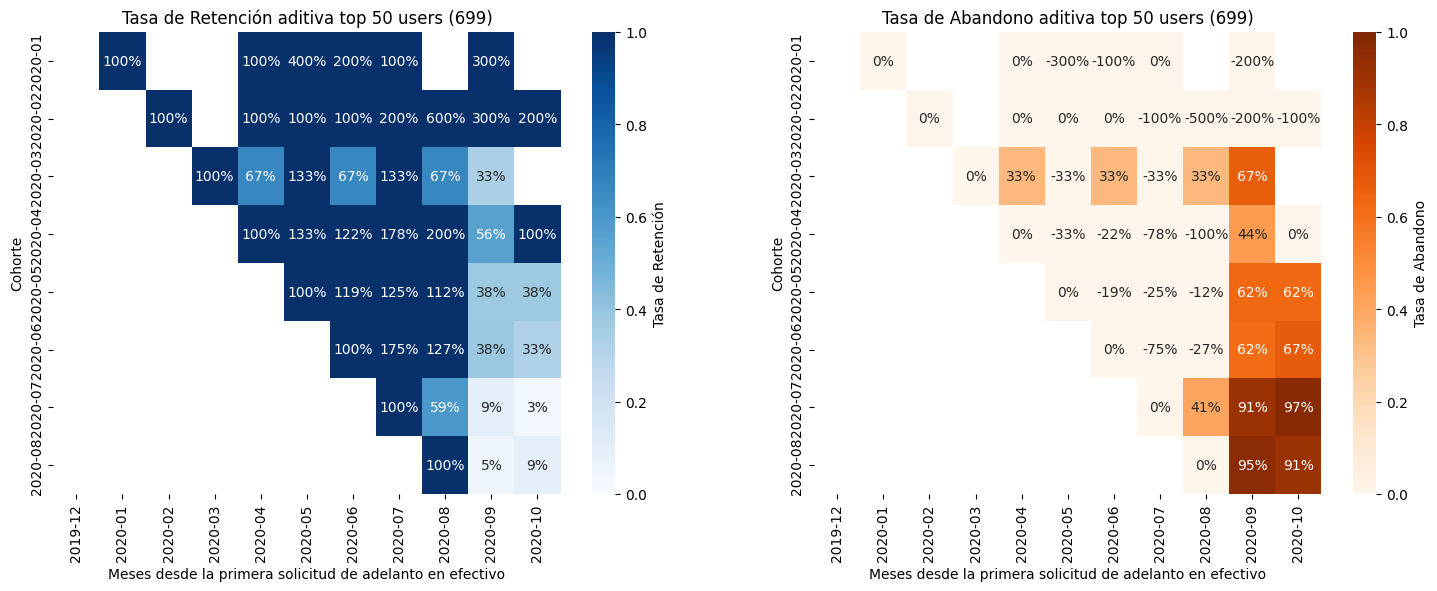

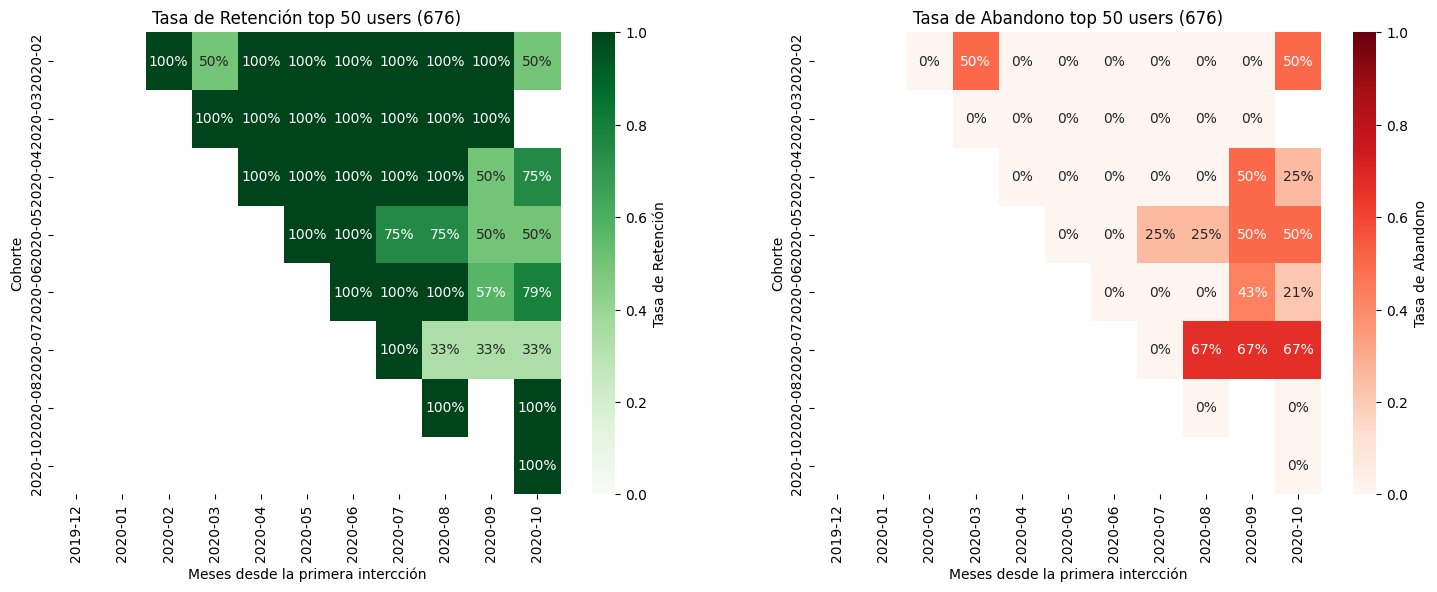

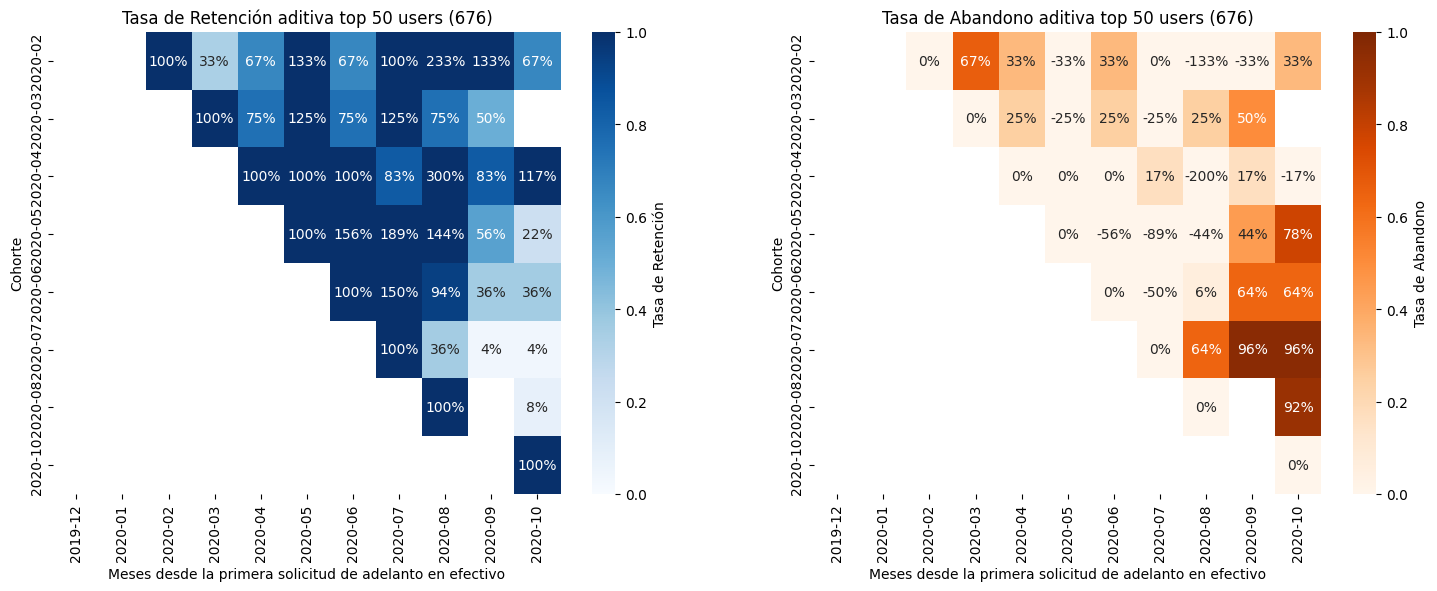

Observación: Los clientes más activos con alta 04-05/2020 tuvieron baja retención en 08-09/2020


In [279]:
ntop = 50

# Buscar clientes con alta retenciónAnalizar tasa de retención de clientes más activos

top_cr_users = data.groupby('user_id').count().sort_values(by='created_at',ascending=False).reset_index().head(ntop)['user_id'].tolist()
top_amount_users = data.groupby('user_id').sum('amount').reset_index().sort_values(by='amount',ascending=False).head(ntop)['user_id']

top_cr_users = data[data['user_id'].isin(top_cr_users)].copy()
top_amount_users = data[data['user_id'].isin(top_amount_users)].copy()

retention_rate_monthly(top_cr_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_cr_users)})')
retention_rate_solicit_monthly(top_cr_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_cr_users)})')
retention_rate_monthly(top_amount_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_amount_users)})')
retention_rate_solicit_monthly(top_amount_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_amount_users)})')

print('Observación: Los clientes más activos con alta 04-05/2020 tuvieron baja retención en 08-09/2020')

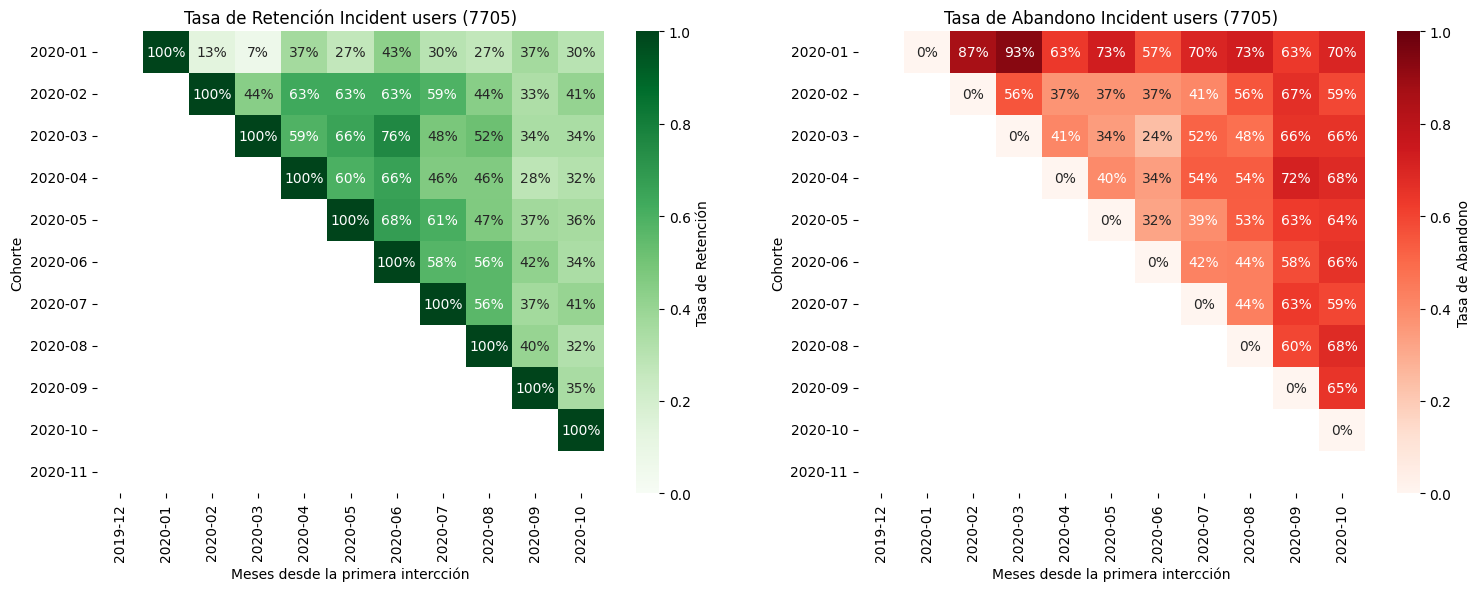

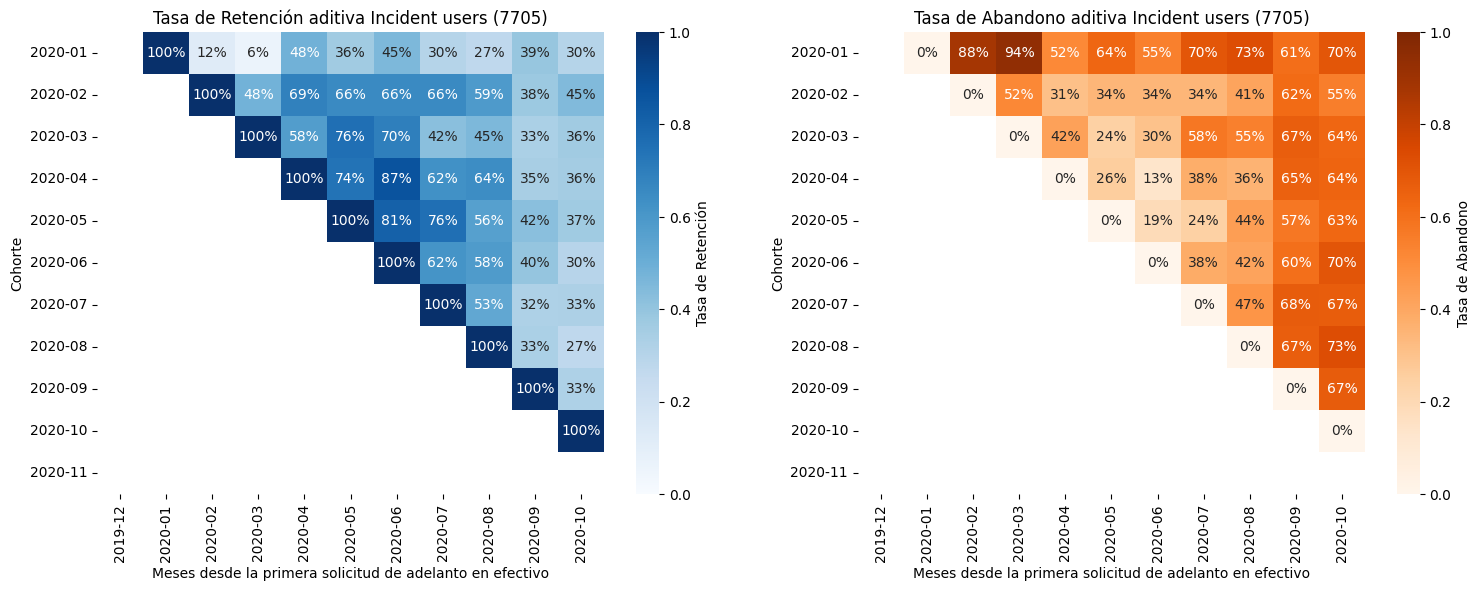

Observación: La tasa de retención de clientes que presentan alguna incidencia en el pago es superior a la media


In [303]:
# Calcular tasas de retención de clientes que tuvieron algún problema de pago

recobery_users = data.groupby('user_id').count().reset_index().query('recovery_status > 0')['user_id'].tolist()
recobery_users = data[data['user_id'].isin(recobery_users)].copy()

retention_rate_monthly(recobery_users, 'user_id', 'created_at', title=f'Incident users ({len(recobery_users)})')
retention_rate_solicit_monthly(recobery_users, 'user_id', 'created_at', title=f'Incident users ({len(recobery_users)})')

print('Observación: La tasa de retención de clientes que presentan alguna incidencia en el pago es superior a la media')